Move midi files in unzipped directory to a single folder

In [12]:
import shutil
import os


  
# Define the source and destination path
path = os.getcwd() + "/CleanedMidiFiles/midi"
destination = os.getcwd() + "/CleanedMidiFiles"

  
# code to move the files from sub-folder to main folder.
dirs = os.listdir(path)
for dir in dirs:
    dirpath = os.path.join(path, dir)
    for file in os.listdir(dirpath):
        filepath = os.path.join(dirpath, file)
        shutil.copy(filepath, destination)

NotADirectoryError: [Errno 20] Not a directory: '/home/sullivana6/Music Encoder/CleanedMidiFiles/midi/out.txt'

Create test dataset from song directory. Skips songs with length shorter than tensors used in training data. Creates a dataset containing the matching song name from the same directory. Saves both as npz archives

In [169]:
import os
import numpy as np
import pypianoroll
from pypianoroll import Multitrack


basepath = os.getcwd() + "/CleanedMidiFiles"
FILENAMES = [f for f in os.listdir(basepath)][::4]


RESULT_FILENAME= './testsongs.npz' 
N_TRACKS = 5
BEAT_RESOLUTION = 12 


results = []
files = []


for filename in FILENAMES:
    
    
    
    
    try:
        multitrack  = pypianoroll.read(os.path.join(basepath, filename)) #beat_resolution=BEAT_RESOLUTION)

    except:
        continue

    multitrack.pad_to_multiple(4 * BEAT_RESOLUTION)
    
    

    # Binarize the pianoroll
    multitrack.binarize()

    # Sort the tracks according to program number
    multitrack.tracks.sort(key=lambda x: x.program)

    # Bring the drum track to the first track
    multitrack.tracks.sort(key=lambda x: ~x.is_drum)
    
    multitrack.trim(0, 4*48)

    # Get the stacked pianoroll
    pianoroll = multitrack.stack()
    
    

    # Skip length shorter than training tensors
    if pianoroll[0, :, 0].shape[0] < 4*4*BEAT_RESOLUTION or pianoroll[:, 0, 0].shape[0] < 5:
        continue

    # Keep only audible pitch range
    pianoroll = pianoroll[:5, :, 24:108]
    #print(pianoroll.shape)
    

    # Reshape and get the phrase pianorolls
    pianoroll = pianoroll.reshape(4, 4 * BEAT_RESOLUTION, 84, N_TRACKS)

        
    results.append(pianoroll)
    
    files.append(filename)

results = np.array(results)
print(results.shape)
files = np.array(files)
print(files.shape)
#result = np.concatenate(result, 0)
#files = np.concatenate(files, 0)
# NOTE: You might want to shuffle the training data here
np.savez_compressed(
    RESULT_FILENAME, songs = results)

np.savez_compressed(
    "files.npz", song_name = files)

/home/sullivana6/.local/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


(1086, 4, 48, 84, 5)
(1086,)


In [170]:
file = np.load('testsongs.npz')

Load trained encoder

In [154]:
import tensorflow as tf
encoder= tf.keras.models.load_model('encoder.h5')

In [172]:
data = file['songs'].reshape(1086, 4, 48, 420)
data = np.swapaxes(data, 1, 3)

Shape out encoded data is 2 sample means x 1086 songs x 2 sample log variances

In [447]:
encoded_data = np.asarray(encoder.predict(data))
encoded_data.shape

(2, 1086, 2)

In [450]:
songnames = np.load('files.npz')
print(songnames['song_name'][0], data[0].shape, encoded_data[:, 0, :].shape)

Voglio vederti danzare.mid (420, 48, 4) (2, 2)


A function that calculates the Euclidean distance between distance between a single song in the test set and the songs within the test dataset. Returns the vector index of the song with the minimum distance.

In [389]:
import numpy as np
def closest_song(song):
    encoded_song = np.asarray(encoder.predict(song))
    mean_i, var_i = encoded_song
    means, var = encoded_data
    vectorized_means= means-mean_i
    #encoded_data[:, 0, 0].reshape(1, 2)
    vectorized_means = vectorized_means*vectorized_means
    vectorized_var = var-var_i
    vectorized_var = vectorized_var*vectorized_var
    distance = vectorized_means+vectorized_var
    return np.argmin(distance[:, 0] + distance [:, 1])

Create euclidean distance vector

In [393]:
distances = []
for song in data:
    song = song.reshape(1,420,48,4)
    distances.append(closest_song(song)

In [394]:
distances

[0,
 1,
 2,
 3,
 4,
 5,
 3,
 7,
 3,
 9,
 10,
 11,
 12,
 3,
 14,
 15,
 16,
 3,
 18,
 19,
 20,
 21,
 22,
 3,
 24,
 25,
 3,
 27,
 3,
 3,
 30,
 31,
 32,
 33,
 34,
 3,
 36,
 3,
 3,
 39,
 40,
 41,
 31,
 43,
 44,
 9,
 3,
 47,
 48,
 3,
 50,
 9,
 52,
 3,
 9,
 55,
 3,
 3,
 58,
 59,
 3,
 61,
 62,
 63,
 64,
 65,
 66,
 3,
 68,
 69,
 9,
 71,
 72,
 73,
 74,
 75,
 3,
 77,
 3,
 79,
 80,
 9,
 82,
 3,
 84,
 85,
 86,
 87,
 88,
 3,
 90,
 3,
 92,
 93,
 3,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 3,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 3,
 116,
 117,
 118,
 119,
 120,
 121,
 3,
 123,
 3,
 125,
 3,
 3,
 3,
 129,
 130,
 3,
 132,
 3,
 134,
 3,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 3,
 3,
 146,
 3,
 148,
 149,
 3,
 151,
 152,
 153,
 154,
 155,
 3,
 157,
 158,
 159,
 160,
 161,
 9,
 163,
 164,
 165,
 166,
 3,
 3,
 3,
 170,
 171,
 172,
 173,
 3,
 3,
 176,
 177,
 3,
 179,
 180,
 3,
 182,
 3,
 3,
 185,
 186,
 3,
 188,
 189,
 190,
 3,
 192,
 193,
 194,
 3,
 196,
 197,
 3,
 

Visualizing test data in a dataframe

In [413]:
import pandas as pd
song_df= pd.DataFrame(songnames["song_name"],  columns = ["Names"])
#song_df["Distance"] = distance
song_df["Closest_song"] = distances
song_df["Correct_song_ID"] = np.arange(0, 1086)
song_df.index.name = "Index"
song_df

,Names,Closest_song,Correct_song_ID
Index,,,
0,Voglio vederti danzare.mid,0,0
1,Der Junge mit der Mundharmonika.mid,1,1
2,You'll See.1.mid,2,2
3,Bring It on Home.mid,3,3
4,Every Little Thing She Does Is Magic.1.mid,4,4
5,Una canzone d'amore.1.mid,5,5
6,Einmal und immer wieder.mid,3,6
7,Endless Dream_ a) Silent Spring (instrumental)...,7,7
8,(What a) Wonderful World.mid,3,8


A song should have smallest Euclidean distance value with itself. Accuracy score compares the index of the song with the smallest Euclidean distance with the Index of the current song. 

In [418]:
len(song_df[song_df["Correct_song_ID"] == song_df["Closest_song"]])/len(song_df)

0.641804788213628

In [429]:
total_loss = np.asarray([1795.7321, 1380.1936, 1366.8640, 1350.7823, 1282.6942, 1249.5950, 1240.5261, 1236.0237, 1232.7563, 1229.7325, 1227.5891, 1225.2075, 1223.2814, 1221.2854, 1219.5289, 1217.7354, 1216.0542, 1214.5704, 1212.7928, 1211.4968, 1210.0194, 1208.6064, 1207.3363, 1206.2471, 1204.8787, 1204.0680, 1202.7902, 1201.6376, 1200.7271, 1199.7687])
recon_loss = np.asarray([1782.9033, 1374.0693, 1360.6814, 1344.7733, 1275.4348, 1243.6759, 1235.4019, 1231.2169, 1228.0643, 1225.1357, 1223.0399, 1220.6815, 1218.7782, 1216.8110, 1215.0919, 1213.3201, 1211.6857, 1210.2128, 1208.4591, 1207.1870, 1205.7271, 1204.3350, 1203.0900, 1202.0099, 1200.6488, 1199.8312, 1198.5688, 1197.4286, 1196.5282, 1195.5559])
kl_loss = total_loss-recon_loss
epoch = np.arange(1, 31)

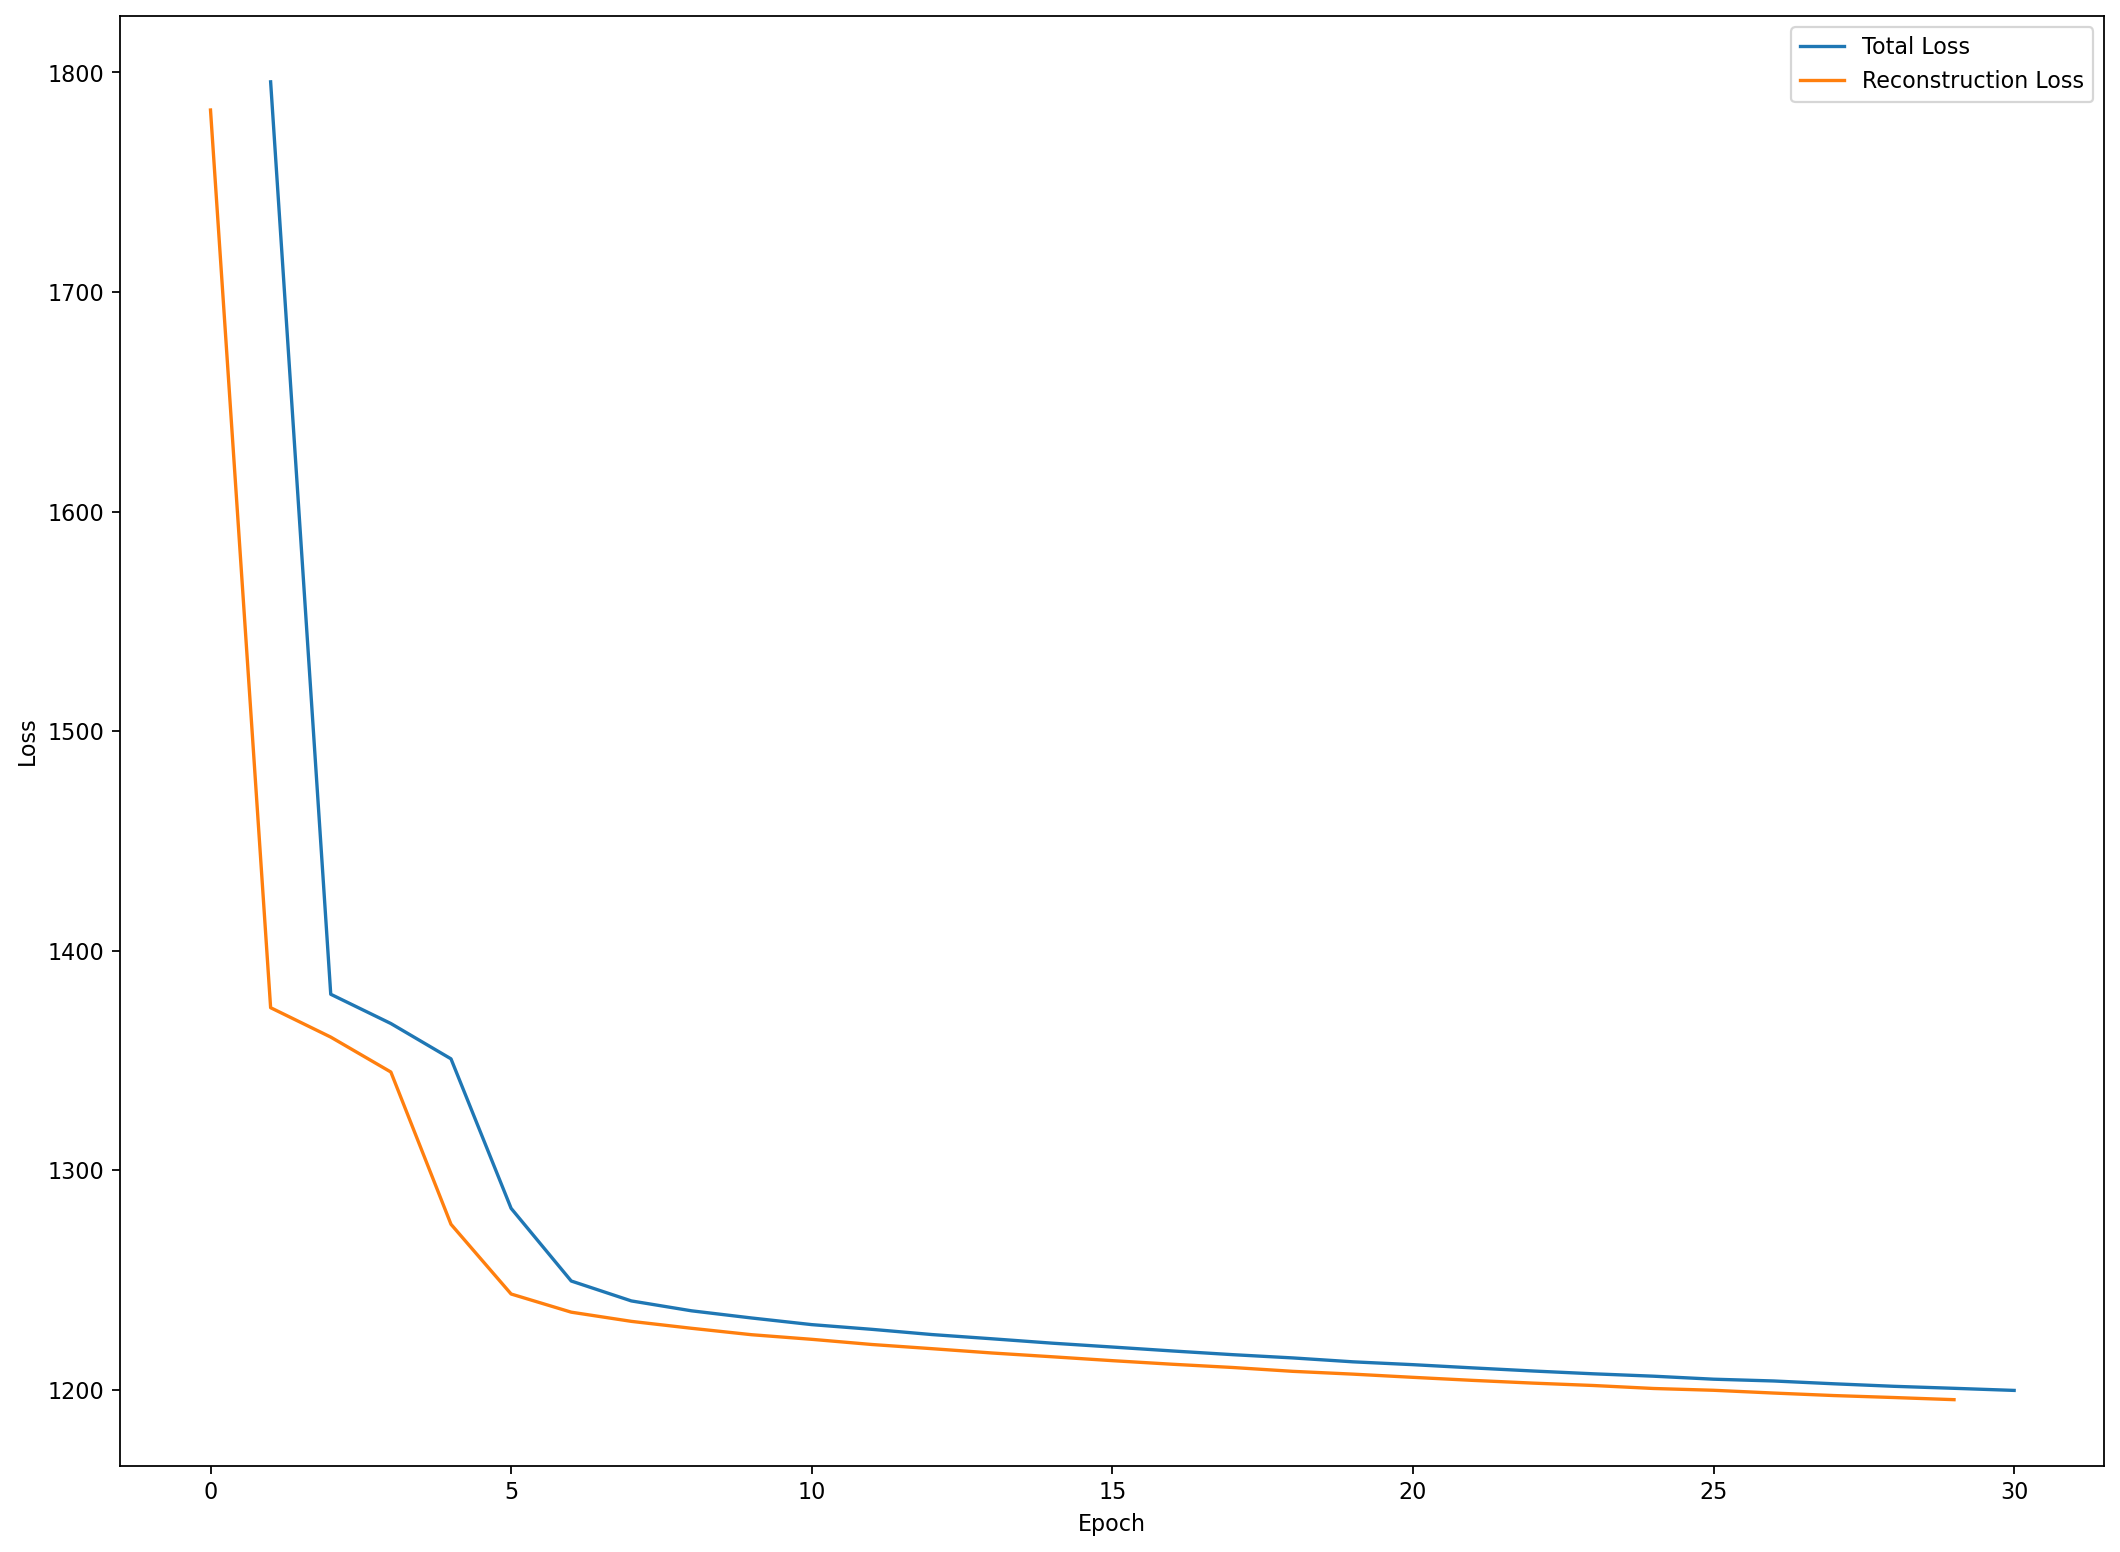

In [445]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
figure(figsize = (16,12), dpi = 160)
sns.set
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(epoch, total_loss)
plt.plot(recon_loss)
plt.legend(["Total Loss", "Reconstruction Loss"])


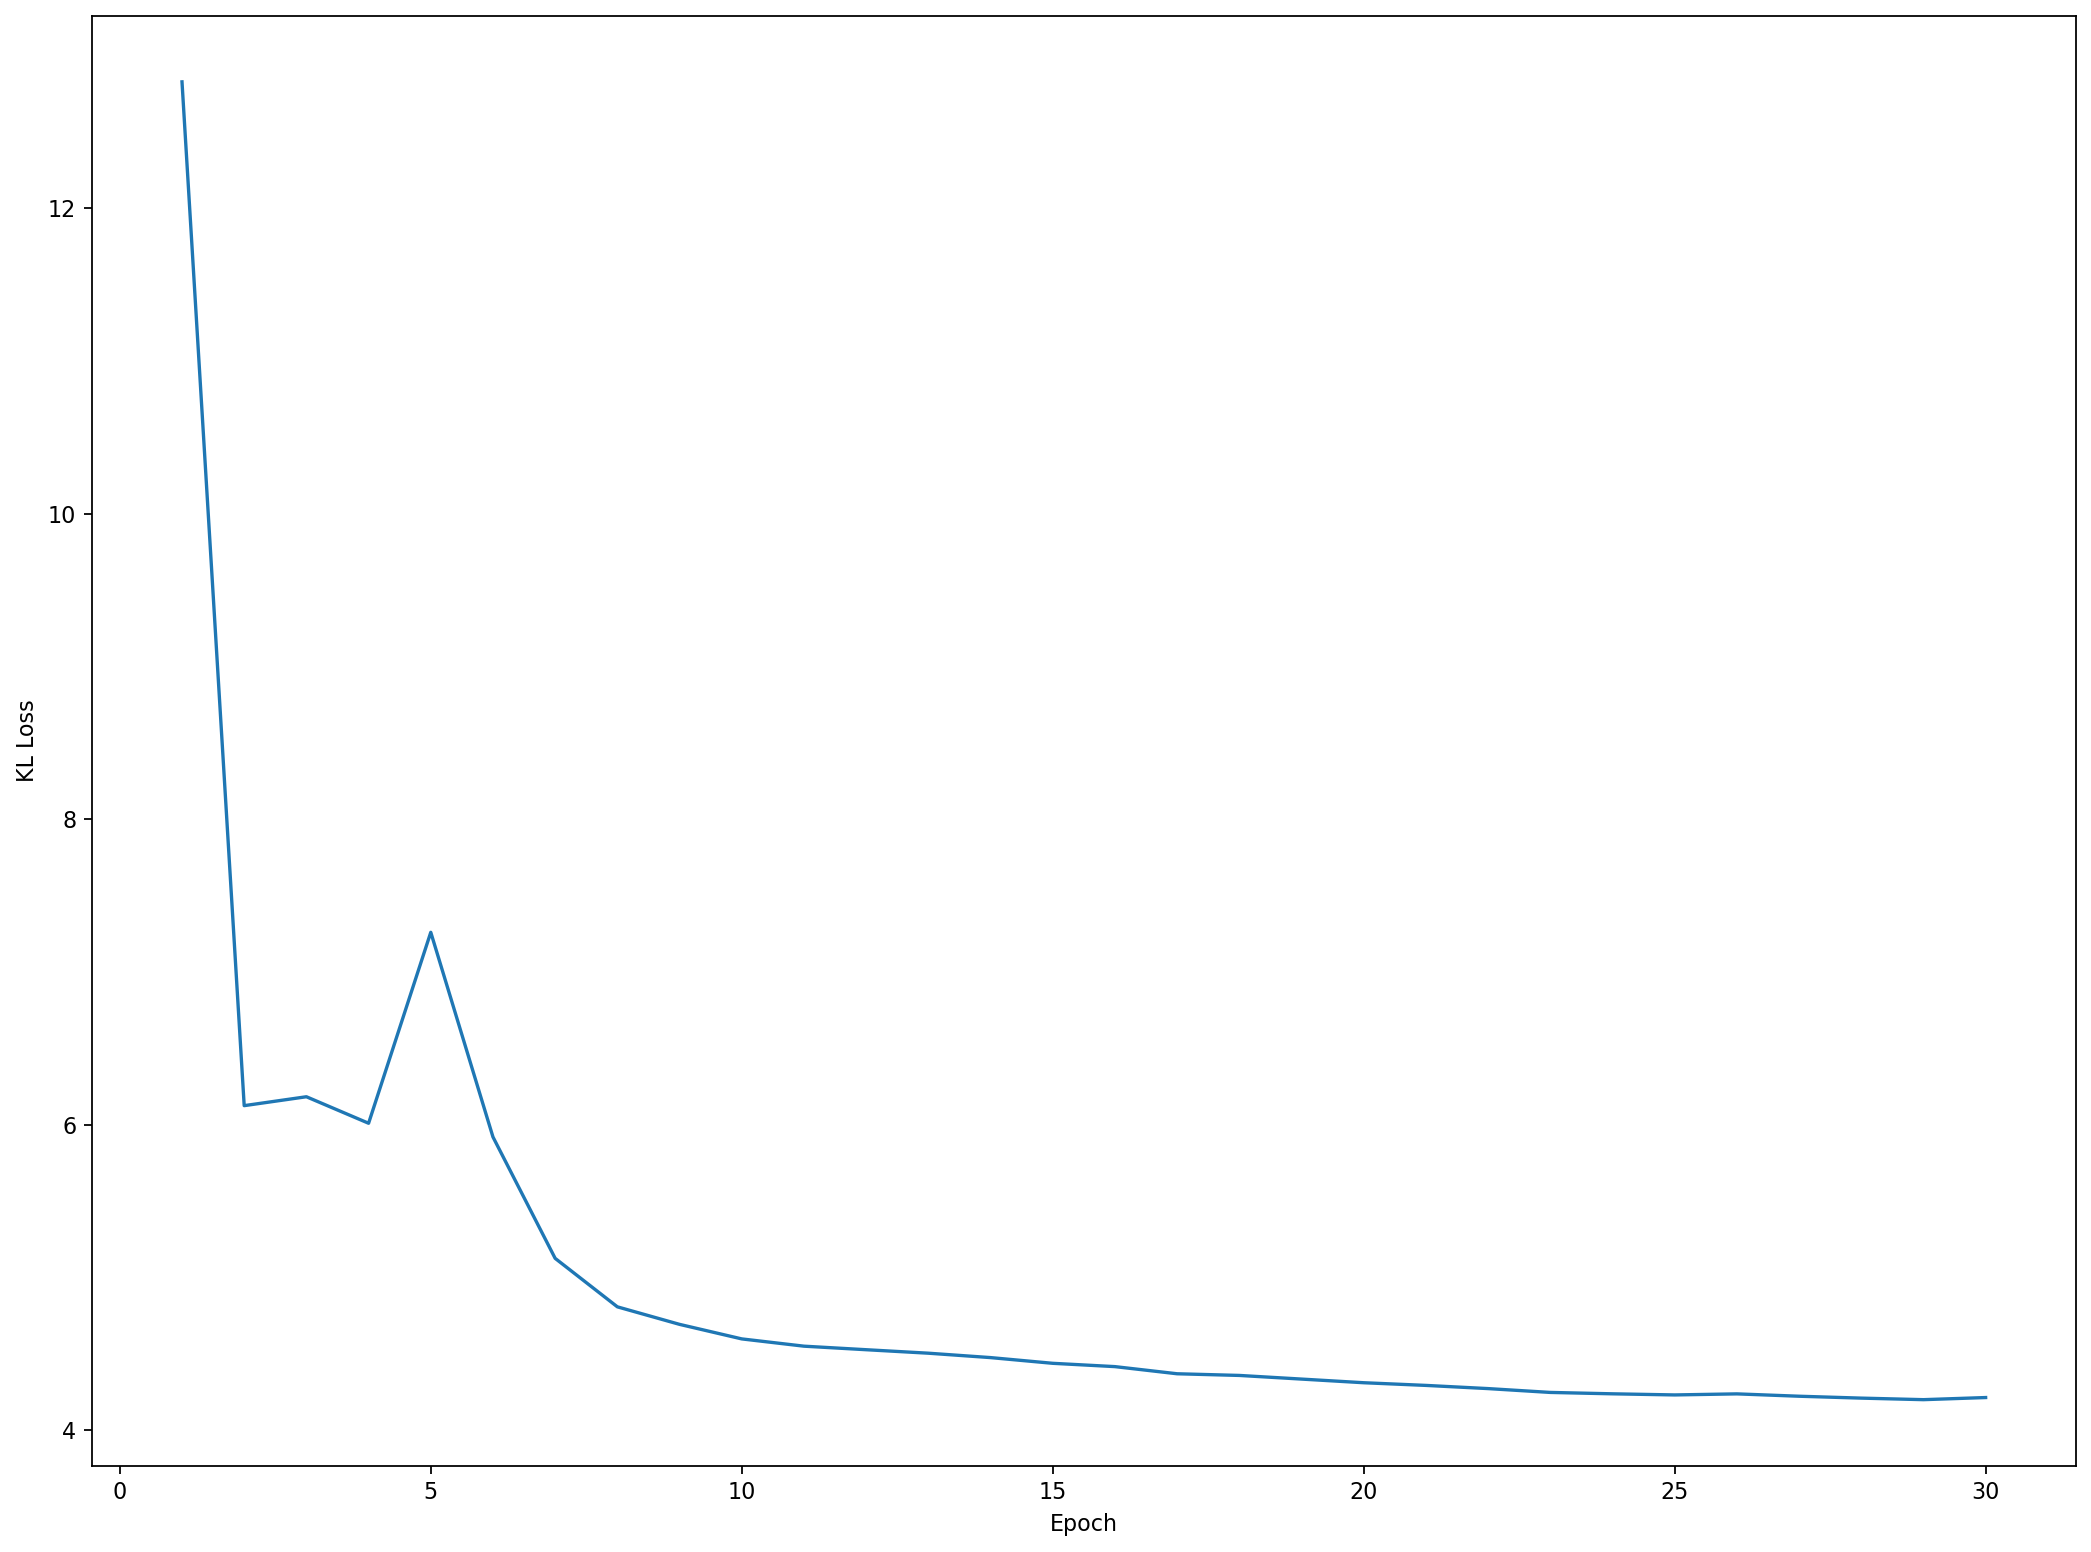

In [446]:
figure(figsize = (16,12), dpi = 160)
sns.set
plt.xlabel("Epoch")
plt.ylabel("KL Loss")

plt.plot(epoch, kl_loss)



In [134]:
def load_data_from_npz(filename):
    """Load and return the training data from a npz file (sparse format)."""
    with np.load(filename) as f:
        data = np.zeros(f['shape'], np.bool_)
        data[[x for x in f['nonzero']]] = True
    return data

In [135]:
data = load_data_from_npz('testsongs.npz')
data.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 4

In [9]:
!unzip cleanmidi.zip -d CleanedMidiFiles

Archive:  cleanmidi.zip
   creating: CleanedMidiFiles/New folder/
   creating: CleanedMidiFiles/New folder/.38 Special/
  inflating: CleanedMidiFiles/New folder/.38 Special/Caught Up In You.mid  
  inflating: CleanedMidiFiles/New folder/.38 Special/Fantasy Girl.mid  
   creating: CleanedMidiFiles/New folder/10,000 Maniacs/
  inflating: CleanedMidiFiles/New folder/10,000 Maniacs/A Campfire Song.mid  
   creating: CleanedMidiFiles/New folder/101 Strings/
  inflating: CleanedMidiFiles/New folder/101 Strings/Theme From The Godfather.mid  
   creating: CleanedMidiFiles/New folder/10cc/
  inflating: CleanedMidiFiles/New folder/10cc/Dreadlock Holiday.1.mid  
  inflating: CleanedMidiFiles/New folder/10cc/Dreadlock Holiday.2.mid  
  inflating: CleanedMidiFiles/New folder/10cc/Dreadlock Holiday.3.mid  
  inflating: CleanedMidiFiles/New folder/10cc/Dreadlock Holiday.4.mid  
  inflating: CleanedMidiFiles/New folder/10cc/Dreadlock Holiday.mid  
  inflating: CleanedMidiFiles/New folder/10cc/I'm Not 

  inflating: CleanedMidiFiles/New folder/A Taste of Honey/Boogie Oogie Oogie.mid  
   creating: CleanedMidiFiles/New folder/a-ha/
  inflating: CleanedMidiFiles/New folder/a-ha/Hunting High and Low.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/Take On Me.1.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/Take On Me.2.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/Take On Me.3.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/Take On Me.4.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/Take On Me.5.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/Take On Me.6.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/Take On Me.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/The Living Daylights.1.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/The Living Daylights.mid  
  inflating: CleanedMidiFiles/New folder/a-ha/The Sun Always Shines on TV.mid  
   creating: CleanedMidiFiles/New folder/Aaliyah/
  inflating: CleanedMidiFiles/New folder/Aaliyah/Are You That Some

  inflating: CleanedMidiFiles/New folder/ABBA/Money, Money, Money.7.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Money, Money, Money.8.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Money, Money, Money.9.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Money, Money, Money.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Move On.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/My Love My Life.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Name of the Game.1.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Name of the Game.2.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Name of the Game.3.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Name of the Game.4.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Name of the Game.5.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Name of the Game.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/Nina Pretty Ballerina.mid  
  inflating: CleanedMidiFiles/New folder/ABBA/One Of Us.mid  
  inflating: Clean

  inflating: CleanedMidiFiles/New folder/Adiemus/Kayama.mid  
   creating: CleanedMidiFiles/New folder/Adriano Celentano/
  inflating: CleanedMidiFiles/New folder/Adriano Celentano/Azzurro.1.mid  
  inflating: CleanedMidiFiles/New folder/Adriano Celentano/Azzurro.mid  
  inflating: CleanedMidiFiles/New folder/Adriano Celentano/Una carezza in un pugno.mid  
  inflating: CleanedMidiFiles/New folder/Adriano Celentano/Una festa sui prati.mid  
   creating: CleanedMidiFiles/New folder/Adventures of Stevie V/
  inflating: CleanedMidiFiles/New folder/Adventures of Stevie V/Dirty Cash (Dime and Dollar mix).mid  
   creating: CleanedMidiFiles/New folder/Aerosmith/
  inflating: CleanedMidiFiles/New folder/Aerosmith/Amazing.1.mid  
  inflating: CleanedMidiFiles/New folder/Aerosmith/Amazing.mid  
  inflating: CleanedMidiFiles/New folder/Aerosmith/Angel.mid  
  inflating: CleanedMidiFiles/New folder/Aerosmith/Blind Man.mid  
  inflating: CleanedMidiFiles/New folder/Aerosmith/Boogie Man.mid  
  infl

  inflating: CleanedMidiFiles/New folder/Alan Jackson/Home.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/I Don't Even Know Your Name.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/I'll Try.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/It Must Be Love.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Little Bitty.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Livin' on Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Livin' on Love.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Love's Got a Hold on You.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Mercury Blues.1.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Mercury Blues.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Summertime Blues.1.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Summertime Blues.2.mid  
  inflating: CleanedMidiFiles/New folder/Alan Jackson/Summertime Blues.mid  
  infla

  inflating: CleanedMidiFiles/New folder/All Saints/Pure Shoes.1.mid  
  inflating: CleanedMidiFiles/New folder/All Saints/Pure Shoes.2.mid  
  inflating: CleanedMidiFiles/New folder/All Saints/Pure Shoes.3.mid  
  inflating: CleanedMidiFiles/New folder/All Saints/Pure Shoes.4.mid  
  inflating: CleanedMidiFiles/New folder/All Saints/Pure Shoes.mid  
  inflating: CleanedMidiFiles/New folder/All Saints/Under the Bridge.1.mid  
  inflating: CleanedMidiFiles/New folder/All Saints/Under the Bridge.mid  
   creating: CleanedMidiFiles/New folder/All-4-One/
  inflating: CleanedMidiFiles/New folder/All-4-One/I Can Love You Like That.1.mid  
  inflating: CleanedMidiFiles/New folder/All-4-One/I Can Love You Like That.mid  
  inflating: CleanedMidiFiles/New folder/All-4-One/I Swear.1.mid  
  inflating: CleanedMidiFiles/New folder/All-4-One/I Swear.2.mid  
  inflating: CleanedMidiFiles/New folder/All-4-One/I Swear.3.mid  
  inflating: CleanedMidiFiles/New folder/All-4-One/I Swear.4.mid  
  inflati

  inflating: CleanedMidiFiles/New folder/Amos, Tori/Raspberry Swirl.mid  
  inflating: CleanedMidiFiles/New folder/Amos, Tori/Smells Like Teen Spirit.mid  
  inflating: CleanedMidiFiles/New folder/Amos, Tori/Spark.mid  
  inflating: CleanedMidiFiles/New folder/Amos, Tori/The Wrong Band.mid  
  inflating: CleanedMidiFiles/New folder/Amos, Tori/Winter.mid  
   creating: CleanedMidiFiles/New folder/Amy Grant/
  inflating: CleanedMidiFiles/New folder/Amy Grant/Baby Baby.1.mid  
  inflating: CleanedMidiFiles/New folder/Amy Grant/Baby Baby.2.mid  
  inflating: CleanedMidiFiles/New folder/Amy Grant/Baby Baby.mid  
  inflating: CleanedMidiFiles/New folder/Amy Grant/Big Yellow Taxi.1.mid  
  inflating: CleanedMidiFiles/New folder/Amy Grant/Big Yellow Taxi.mid  
  inflating: CleanedMidiFiles/New folder/Amy Grant/Doubly Good to You.1.mid  
  inflating: CleanedMidiFiles/New folder/Amy Grant/Doubly Good to You.mid  
  inflating: CleanedMidiFiles/New folder/Amy Grant/El Shaddai.1.mid  
  inflating: 

  inflating: CleanedMidiFiles/New folder/Andrew Lloyd Webber/The Phantom of the Opera_ Act II. The Point of No Return (Phantom, Christine).mid  
   creating: CleanedMidiFiles/New folder/Andy Kim/
  inflating: CleanedMidiFiles/New folder/Andy Kim/Baby I Love You.1.mid  
  inflating: CleanedMidiFiles/New folder/Andy Kim/Baby I Love You.mid  
  inflating: CleanedMidiFiles/New folder/Andy Kim/Rock Me Gently.mid  
   creating: CleanedMidiFiles/New folder/Andy Williams/
  inflating: CleanedMidiFiles/New folder/Andy Williams/(Where Do I Begin) Love Story.mid  
  inflating: CleanedMidiFiles/New folder/Andy Williams/Battle Hymn of the Republic.mid  
  inflating: CleanedMidiFiles/New folder/Andy Williams/Can't Get Used To Losing You.mid  
  inflating: CleanedMidiFiles/New folder/Andy Williams/MacArthur Park.mid  
  inflating: CleanedMidiFiles/New folder/Andy Williams/The Impossible Dream.mid  
   creating: CleanedMidiFiles/New folder/Angelo Branduardi/
  inflating: CleanedMidiFiles/New folder/An

  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Settembre.1.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Settembre.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Sotto il segno dei pesci.1.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Sotto il segno dei pesci.2.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Sotto il segno dei pesci.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Sotto la pioggia.1.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Sotto la pioggia.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Stai con me.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Stella.mid  
  inflating: CleanedMidiFiles/New folder/Antonello Venditti/Vento selvaggio.mid  
   creating: CleanedMidiFiles/New folder/Antonio Carlos/
  inflating: CleanedMidiFiles/New folder/Antonio Carlos/Insensatez (How Insensitive).mid  
   creating: Cleaned

  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/Let It Ride.mid  
  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/Takin Care of Business.1.mid  
  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/Takin Care of Business.2.mid  
  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/Takin Care of Business.3.mid  
  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/Takin Care of Business.4.mid  
  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/Takin Care of Business.mid  
  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/You Ain't Seen Nothin Yet.1.mid  
  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/You Ain't Seen Nothin Yet.2.mid  
  inflating: CleanedMidiFiles/New folder/Bachman-Turner Overdrive/You Ain't Seen Nothin Yet.mid  
   creating: CleanedMidiFiles/New folder/Backstreet Boys/
  inflating: CleanedMidiFiles/New folder/Backstreet Boys/10,000 Promises.mid 

  inflating: CleanedMidiFiles/New folder/Basie/Ain't Misbehavin'.mid  
  inflating: CleanedMidiFiles/New folder/Basie/All of Me.mid  
  inflating: CleanedMidiFiles/New folder/Basie/April in Paris.mid  
  inflating: CleanedMidiFiles/New folder/Basie/Basie - Straight Ahead.mid  
  inflating: CleanedMidiFiles/New folder/Basie/Cute.mid  
  inflating: CleanedMidiFiles/New folder/Basie/Doin' Basie's Thing.mid  
  inflating: CleanedMidiFiles/New folder/Basie/Fly Me to the Moon.mid  
  inflating: CleanedMidiFiles/New folder/Basie/Freckle Face.mid  
  inflating: CleanedMidiFiles/New folder/Basie/Have a Nice Day.mid  
  inflating: CleanedMidiFiles/New folder/Basie/Hay Burner.mid  
  inflating: CleanedMidiFiles/New folder/Basie/I Left My Heart in San Francisco.mid  
  inflating: CleanedMidiFiles/New folder/Basie/In a Mellow Tone.mid  
  inflating: CleanedMidiFiles/New folder/Basie/It Had to Be You.mid  
  inflating: CleanedMidiFiles/New folder/Basie/Katy.mid  
  inflating: CleanedMidiFiles/New fo

  inflating: CleanedMidiFiles/New folder/Battisti/Un'avventura.3.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Un'avventura.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una donna per amico.1.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una donna per amico.2.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una donna per amico.3.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una donna per amico.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una giornata uggiosa.1.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una giornata uggiosa.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una montagna.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una poltrona.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Una vita viva.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Vendo casa.mid  
  inflating: CleanedMidiFiles/New folder/Battisti/Vento nel vento.mid  
  inflating: CleanedMidiFiles/New folder/Battis

  inflating: CleanedMidiFiles/New folder/Berte/In alto mare.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Luna.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Mi manchi.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Ninna nanna.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Non sono una signora.1.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Non sono una signora.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Portami con te.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Ragazzo mio.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Sei bellissima.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Solitudini.mid  
  inflating: CleanedMidiFiles/New folder/Berte/Stiamo come stiamo.mid  
   creating: CleanedMidiFiles/New folder/Bertie Higgins/
  inflating: CleanedMidiFiles/New folder/Bertie Higgins/Key Largo.1.mid  
  inflating: CleanedMidiFiles/New folder/Bertie Higgins/Key Largo.mid  
   creating: CleanedMidiFiles/New folder/Bette Midler/
  i

  inflating: CleanedMidiFiles/New folder/Billy Joel/The Longest Time.1.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The Longest Time.2.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The Longest Time.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The Mexican Connection.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The River of Dreams.1.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The River of Dreams.2.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The River of Dreams.3.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The River of Dreams.4.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The River of Dreams.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The Stranger.1.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The Stranger.2.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The Stranger.3.mid  
  inflating: CleanedMidiFiles/New folder/Billy Joel/The Stranger.mid  
  

  inflating: CleanedMidiFiles/New folder/Black Sabbath/War Pigs.mid  
   creating: CleanedMidiFiles/New folder/Blackstreet/
  inflating: CleanedMidiFiles/New folder/Blackstreet/Don't Leave Me.mid  
  inflating: CleanedMidiFiles/New folder/Blackstreet/Good Lovin'.mid  
  inflating: CleanedMidiFiles/New folder/Blackstreet/No Diggity.1.mid  
  inflating: CleanedMidiFiles/New folder/Blackstreet/No Diggity.mid  
  inflating: CleanedMidiFiles/New folder/Blackstreet/Take Me There (feat. Mya, Ma$e & Blinky Blink).mid  
   creating: CleanedMidiFiles/New folder/Blaque/
  inflating: CleanedMidiFiles/New folder/Blaque/Bring It All to Me.mid  
   creating: CleanedMidiFiles/New folder/Blattschuss/
  inflating: CleanedMidiFiles/New folder/Blattschuss/Kreuzberger Nachte.mid  
   creating: CleanedMidiFiles/New folder/Blind Guardian/
  inflating: CleanedMidiFiles/New folder/Blind Guardian/Time What Is Time.mid  
   creating: CleanedMidiFiles/New folder/Blind Melon/
  inflating: CleanedMidiFiles/New fold

  inflating: CleanedMidiFiles/New folder/Bob Dylan/Rainy Day Women #12 & 35.mid  
  inflating: CleanedMidiFiles/New folder/Bob Dylan/Subterranean Homesick Blues.mid  
   creating: CleanedMidiFiles/New folder/Bob James/
  inflating: CleanedMidiFiles/New folder/Bob James/Orpheus.mid  
   creating: CleanedMidiFiles/New folder/Bob Marley/
  inflating: CleanedMidiFiles/New folder/Bob Marley/Could You Be Loved.mid  
  inflating: CleanedMidiFiles/New folder/Bob Marley/Exodus.mid  
  inflating: CleanedMidiFiles/New folder/Bob Marley/I shot the Sheriff.mid  
  inflating: CleanedMidiFiles/New folder/Bob Marley/Is This Love.mid  
  inflating: CleanedMidiFiles/New folder/Bob Marley/Jammin'.mid  
  inflating: CleanedMidiFiles/New folder/Bob Marley/Punky Reggae Party.mid  
  inflating: CleanedMidiFiles/New folder/Bob Marley/Redemption Song.mid  
  inflating: CleanedMidiFiles/New folder/Bob Marley/Three Little Birds.mid  
  inflating: CleanedMidiFiles/New folder/Bob Marley/Waiting In Vain.mid  
   cr

  inflating: CleanedMidiFiles/New folder/Booker T. & The MG's/Green Onions.mid  
  inflating: CleanedMidiFiles/New folder/Booker T. & The MG's/Hip Hug-Her.mid  
   creating: CleanedMidiFiles/New folder/Booming Support/
  inflating: CleanedMidiFiles/New folder/Booming Support/Rode schoentjes.mid  
   creating: CleanedMidiFiles/New folder/Boothe, Ken/
  inflating: CleanedMidiFiles/New folder/Boothe, Ken/Everything I Own.mid  
   creating: CleanedMidiFiles/New folder/Borg Andy/
  inflating: CleanedMidiFiles/New folder/Borg Andy/Adios amor.1.mid  
  inflating: CleanedMidiFiles/New folder/Borg Andy/Adios amor.mid  
  inflating: CleanedMidiFiles/New folder/Borg Andy/Arrivederci Claire.mid  
  inflating: CleanedMidiFiles/New folder/Borg Andy/Einmal und immer wieder.mid  
  inflating: CleanedMidiFiles/New folder/Borg Andy/Ich brauch dich jeden Tag.mid  
  inflating: CleanedMidiFiles/New folder/Borg Andy/Ich brauch ein bisschen Gluck.1.mid  
  inflating: CleanedMidiFiles/New folder/Borg Andy/Ic

  inflating: CleanedMidiFiles/New folder/Bread/Guitar Man.mid  
  inflating: CleanedMidiFiles/New folder/Bread/If.1.mid  
  inflating: CleanedMidiFiles/New folder/Bread/If.2.mid  
  inflating: CleanedMidiFiles/New folder/Bread/If.3.mid  
  inflating: CleanedMidiFiles/New folder/Bread/If.4.mid  
  inflating: CleanedMidiFiles/New folder/Bread/If.5.mid  
  inflating: CleanedMidiFiles/New folder/Bread/If.6.mid  
  inflating: CleanedMidiFiles/New folder/Bread/If.7.mid  
  inflating: CleanedMidiFiles/New folder/Bread/If.mid  
  inflating: CleanedMidiFiles/New folder/Bread/It Don't Matter to Me.1.mid  
  inflating: CleanedMidiFiles/New folder/Bread/It Don't Matter to Me.mid  
  inflating: CleanedMidiFiles/New folder/Bread/Lost Without Your Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Bread/Lost Without Your Love.mid  
  inflating: CleanedMidiFiles/New folder/Bread/Make It With You.1.mid  
  inflating: CleanedMidiFiles/New folder/Bread/Make It With You.2.mid  
  inflating: CleanedMidi

  inflating: CleanedMidiFiles/New folder/Brooks & Dunn/Whiskey Under the Bridge.mid  
   creating: CleanedMidiFiles/New folder/Brooks Garth/
  inflating: CleanedMidiFiles/New folder/Brooks Garth/Ain't Goin' Down ('til the Sun Comes Up).1.mid  
  inflating: CleanedMidiFiles/New folder/Brooks Garth/Ain't Goin' Down ('til the Sun Comes Up).2.mid  
  inflating: CleanedMidiFiles/New folder/Brooks Garth/Ain't Goin' Down ('til the Sun Comes Up).mid  
  inflating: CleanedMidiFiles/New folder/Brooks Garth/American Honky-Tonk Bar Association.1.mid  
  inflating: CleanedMidiFiles/New folder/Brooks Garth/American Honky-Tonk Bar Association.mid  
  inflating: CleanedMidiFiles/New folder/Brooks Garth/Callin' Baton Rouge.1.mid  
  inflating: CleanedMidiFiles/New folder/Brooks Garth/Callin' Baton Rouge.2.mid  
  inflating: CleanedMidiFiles/New folder/Brooks Garth/Callin' Baton Rouge.mid  
  inflating: CleanedMidiFiles/New folder/Brooks Garth/Friends in Low Places.1.mid  
  inflating: CleanedMidiFiles/

  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/Pink Cadillac.mid  
  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/Streets of Philadelphia.1.mid  
  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/Streets of Philadelphia.2.mid  
  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/Streets of Philadelphia.mid  
  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/Tenth Avenue Freeze-Out.1.mid  
  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/Tenth Avenue Freeze-Out.mid  
  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/The Rising.mid  
  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/The River.1.mid  
  inflating: CleanedMidiFiles/New folder/Bruce Springsteen/The River.mid  
   creating: CleanedMidiFiles/New folder/Brunner & Brunner/
  inflating: CleanedMidiFiles/New folder/Brunner & Brunner/Bis in alle Ewigkeit.mid  
  inflating: CleanedMidiFiles/New folder/Brunner & Brunner/Du bist Leben fur mich.mid  
  inflat

  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.1.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.2.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.3.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.4.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.5.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.6.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.7.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.8.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Summer of '69.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/The Best of Me.1.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/The Best of Me.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/This Time.mid  
  inflating: CleanedMidiFiles/New folder/Bryan Adams/Thought I'd Died and Gone to Heaven.1.mid  
  inflating

   creating: CleanedMidiFiles/New folder/Captain Hollywood Project/
  inflating: CleanedMidiFiles/New folder/Captain Hollywood Project/Find Another Way (single mix).mid  
  inflating: CleanedMidiFiles/New folder/Captain Hollywood Project/Flying High (single mix).mid  
  inflating: CleanedMidiFiles/New folder/Captain Hollywood Project/Impossible.mid  
  inflating: CleanedMidiFiles/New folder/Captain Hollywood Project/More and More.mid  
  inflating: CleanedMidiFiles/New folder/Captain Hollywood Project/Only With You (Faze 2 edit).mid  
   creating: CleanedMidiFiles/New folder/Captain Jack/
  inflating: CleanedMidiFiles/New folder/Captain Jack/Drill Instructor.1.mid  
  inflating: CleanedMidiFiles/New folder/Captain Jack/Drill Instructor.mid  
  inflating: CleanedMidiFiles/New folder/Captain Jack/Little Boy.mid  
  inflating: CleanedMidiFiles/New folder/Captain Jack/Soldier Soldier.mid  
   creating: CleanedMidiFiles/New folder/Carboni/
  inflating: CleanedMidiFiles/New folder/Carboni/Ci

   creating: CleanedMidiFiles/New folder/Cathy Dennis/
  inflating: CleanedMidiFiles/New folder/Cathy Dennis/Too Many Walls.mid  
   creating: CleanedMidiFiles/New folder/Cats/
  inflating: CleanedMidiFiles/New folder/Cats/Let's Dance.1.mid  
  inflating: CleanedMidiFiles/New folder/Cats/Let's Dance.mid  
  inflating: CleanedMidiFiles/New folder/Cats/One Way Wind.1.mid  
  inflating: CleanedMidiFiles/New folder/Cats/One Way Wind.mid  
  inflating: CleanedMidiFiles/New folder/Cats/Save the Last Dance for Me.mid  
  inflating: CleanedMidiFiles/New folder/Cats/Vaya Con Dios.1.mid  
  inflating: CleanedMidiFiles/New folder/Cats/Vaya Con Dios.mid  
   creating: CleanedMidiFiles/New folder/Caught in the Act/
  inflating: CleanedMidiFiles/New folder/Caught in the Act/Love Is Everywhere.mid  
  inflating: CleanedMidiFiles/New folder/Caught in the Act/My Arms Keep Missing You.mid  
   creating: CleanedMidiFiles/New folder/CB Milton/
  inflating: CleanedMidiFiles/New folder/CB Milton/It's a Love

  inflating: CleanedMidiFiles/New folder/Celine Dion/I Hate You Then I Love You.1.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/I Hate You Then I Love You.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/I'm Alive.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/I'm Loving Every Moment With You.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/I'm Your Angel.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/If You Asked Me To.1.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/If You Asked Me To.2.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/If You Asked Me To.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/Immortality.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/It's All Coming Back to Me Now (Classic Paradise radio mix #2).mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/It's All Coming Back to Me.1.mid  
  inflating: CleanedMidiFiles/New folder/Celine Dion/It's All Coming Bac

   creating: CleanedMidiFiles/New folder/Cheer/
  inflating: CleanedMidiFiles/New folder/Cheer/Time for More Walking.mid  
   creating: CleanedMidiFiles/New folder/Cher/
  inflating: CleanedMidiFiles/New folder/Cher/Bang Bang (My Baby Shot Me Down).mid  
  inflating: CleanedMidiFiles/New folder/Cher/Believe.1.mid  
  inflating: CleanedMidiFiles/New folder/Cher/Believe.2.mid  
  inflating: CleanedMidiFiles/New folder/Cher/Believe.mid  
  inflating: CleanedMidiFiles/New folder/Cher/Dov'e L'amore.mid  
  inflating: CleanedMidiFiles/New folder/Cher/Flamenco Dance, Part 2.mid  
  inflating: CleanedMidiFiles/New folder/Cher/Gypsies, Tramps & Thieves.mid  
  inflating: CleanedMidiFiles/New folder/Cher/I Got You Babe.mid  
  inflating: CleanedMidiFiles/New folder/Cher/If I Could Turn Back Time.1.mid  
  inflating: CleanedMidiFiles/New folder/Cher/If I Could Turn Back Time.2.mid  
  inflating: CleanedMidiFiles/New folder/Cher/If I Could Turn Back Time.mid  
  inflating: CleanedMidiFiles/New fol

  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Etude in E major, Op. 10 No. 3_ Lento, ma non troppo.2.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Etude in E major, Op. 10 No. 3_ Lento, ma non troppo.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Etude No. 24 in C minor _Ocean_, Op. 25 No. 12.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Fantaisie impromptu.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Heroic Polonaise No. 6 in A flat, Opus 53.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Larghetto.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Mazurka D-Dur, Op. 33 Nr. 2.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Mazurka Nr. 51 f -moll op. 68 Nr. 4.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Nocturne In C Minor, Op. 48 Nr. 1.mid  
  inflating: CleanedMidiFiles/New folder/Chopin Frederic/Nocturne in F minor, Op. 55 No. 1.mid  
  inflating

  inflating: CleanedMidiFiles/New folder/Christopher Cross/Ride Like The Wind.1.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Ride Like The Wind.2.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Ride Like The Wind.3.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Ride Like The Wind.4.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Ride Like The Wind.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Sailing.1.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Sailing.2.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Sailing.3.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Sailing.4.mid  
  inflating: CleanedMidiFiles/New folder/Christopher Cross/Sailing.mid  
   creating: CleanedMidiFiles/New folder/Chuck Berry/
  inflating: CleanedMidiFiles/New folder/Chuck Berry/Johnny B Goode.1.mid  
  inflating: CleanedMidiFiles/New folder/Chuck Berry/Johnny B Goode.2

  inflating: CleanedMidiFiles/New folder/Clouseau/Zie me graag.mid  
   creating: CleanedMidiFiles/New folder/Clout/
  inflating: CleanedMidiFiles/New folder/Clout/Save Me.mid  
  inflating: CleanedMidiFiles/New folder/Clout/Substitute.1.mid  
  inflating: CleanedMidiFiles/New folder/Clout/Substitute.mid  
   creating: CleanedMidiFiles/New folder/Club Nouveau/
  inflating: CleanedMidiFiles/New folder/Club Nouveau/Lean on Me.mid  
   creating: CleanedMidiFiles/New folder/Coasters/
  inflating: CleanedMidiFiles/New folder/Coasters/Charlie Brown.mid  
  inflating: CleanedMidiFiles/New folder/Coasters/Yakety Yak.mid  
   creating: CleanedMidiFiles/New folder/Cocciante/
  inflating: CleanedMidiFiles/New folder/Cocciante/A mano a mano.mid  
  inflating: CleanedMidiFiles/New folder/Cocciante/Ammassati e distanti.mid  
  inflating: CleanedMidiFiles/New folder/Cocciante/Bella senz'anima.1.mid  
  inflating: CleanedMidiFiles/New folder/Cocciante/Bella senz'anima.mid  
  inflating: CleanedMidiFil

  inflating: CleanedMidiFiles/New folder/Collins Phil/One More Night.6.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/One More Night.7.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/One More Night.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/Saturday Night and Sunday Morning.1.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/Saturday Night and Sunday Morning.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/Something Happened on the Way to Heaven.1.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/Something Happened on the Way to Heaven.2.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/Something Happened on the Way to Heaven.3.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/Something Happened on the Way to Heaven.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/Sussudio.1.mid  
  inflating: CleanedMidiFiles/New folder/Collins Phil/Sussudio.2.mid  
  inflating: CleanedMidiFiles/New

  inflating: CleanedMidiFiles/New folder/Creed/Higher.mid  
  inflating: CleanedMidiFiles/New folder/Creed/My Own Prison.1.mid  
  inflating: CleanedMidiFiles/New folder/Creed/My Own Prison.mid  
  inflating: CleanedMidiFiles/New folder/Creed/My Sacrifice.mid  
  inflating: CleanedMidiFiles/New folder/Creed/One Last Breath.mid  
  inflating: CleanedMidiFiles/New folder/Creed/Torn.mid  
  inflating: CleanedMidiFiles/New folder/Creed/What's This Life For.mid  
  inflating: CleanedMidiFiles/New folder/Creed/With Arms Wide Open (Strings version).1.mid  
  inflating: CleanedMidiFiles/New folder/Creed/With Arms Wide Open (Strings version).2.mid  
  inflating: CleanedMidiFiles/New folder/Creed/With Arms Wide Open (Strings version).mid  
   creating: CleanedMidiFiles/New folder/Creedence Clearwater Revival/
  inflating: CleanedMidiFiles/New folder/Creedence Clearwater Revival/Bad Moon Rising.1.mid  
  inflating: CleanedMidiFiles/New folder/Creedence Clearwater Revival/Bad Moon Rising.2.mid  
 

  inflating: CleanedMidiFiles/New folder/Culture Beat/Anything.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Crying in the Rain.1.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Crying in the Rain.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Got to Get It.1.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Got to Get It.2.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Got to Get It.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Inside Out.1.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Inside Out.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Mr Vain (Mr Trance).1.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Mr Vain (Mr Trance).2.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Mr Vain (Mr Trance).3.mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/Mr Vain (Mr Trance).mid  
  inflating: CleanedMidiFiles/New folder/Culture Beat/World in Your Hands.m

  inflating: CleanedMidiFiles/New folder/Daniele/Fatte 'na pizza.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Gente distratta.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/I say i' sto' cca.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Il pianeta delle parole.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Io per lei.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Io vivo come te.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Je so' pazzo.1.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Je so' pazzo.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Je sto vicino a te.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Musica musica.1.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Musica musica.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Neve al sole.1.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Neve al sole.mid  
  inflating: CleanedMidiFiles/New folder/Daniele/Non ho paura del mostro.mid  


  inflating: CleanedMidiFiles/New folder/Def Leppard/Love Bites.mid  
  inflating: CleanedMidiFiles/New folder/Def Leppard/Miss You in a Heartbeat.mid  
  inflating: CleanedMidiFiles/New folder/Def Leppard/Photograph.1.mid  
  inflating: CleanedMidiFiles/New folder/Def Leppard/Photograph.mid  
  inflating: CleanedMidiFiles/New folder/Def Leppard/Two Steps Behind.1.mid  
  inflating: CleanedMidiFiles/New folder/Def Leppard/Two Steps Behind.mid  
  inflating: CleanedMidiFiles/New folder/Def Leppard/When Love and Hate Collide.mid  
  inflating: CleanedMidiFiles/New folder/Def Leppard/Women.mid  
   creating: CleanedMidiFiles/New folder/Deftones/
  inflating: CleanedMidiFiles/New folder/Deftones/Be Quiet and Drive (Far Away).mid  
  inflating: CleanedMidiFiles/New folder/Deftones/My Own Summer (Shove It).mid  
  inflating: CleanedMidiFiles/New folder/Deftones/Root.mid  
   creating: CleanedMidiFiles/New folder/Del Shannon/
  inflating: CleanedMidiFiles/New folder/Del Shannon/Keep Searchin'

  inflating: CleanedMidiFiles/New folder/Dick Hyman/Oh, Lady Be Good!.mid  
  inflating: CleanedMidiFiles/New folder/Dick Hyman/Where or When.mid  
   creating: CleanedMidiFiles/New folder/Die Arzte/
  inflating: CleanedMidiFiles/New folder/Die Arzte/3-Tage-Bart.mid  
  inflating: CleanedMidiFiles/New folder/Die Arzte/Ein Song namens Schunder.mid  
  inflating: CleanedMidiFiles/New folder/Die Arzte/Friedenspanzer.1.mid  
  inflating: CleanedMidiFiles/New folder/Die Arzte/Friedenspanzer.mid  
  inflating: CleanedMidiFiles/New folder/Die Arzte/Schrei nach Liebe.mid  
   creating: CleanedMidiFiles/New folder/Die Doofen/
  inflating: CleanedMidiFiles/New folder/Die Doofen/Prinzessin De Bahia Tropical.mid  
   creating: CleanedMidiFiles/New folder/Die Fantastischen Vier/
  inflating: CleanedMidiFiles/New folder/Die Fantastischen Vier/Sie Ist Weg.1.mid  
  inflating: CleanedMidiFiles/New folder/Die Fantastischen Vier/Sie Ist Weg.mid  
   creating: CleanedMidiFiles/New folder/Dietrich Marlene

  inflating: CleanedMidiFiles/New folder/Don Johnson/Heartbeat.mid  
  inflating: CleanedMidiFiles/New folder/Don Johnson/Tell It Like It Is.1.mid  
  inflating: CleanedMidiFiles/New folder/Don Johnson/Tell It Like It Is.mid  
   creating: CleanedMidiFiles/New folder/Don McLean/
  inflating: CleanedMidiFiles/New folder/Don McLean/American Pie.1.mid  
  inflating: CleanedMidiFiles/New folder/Don McLean/American Pie.2.mid  
  inflating: CleanedMidiFiles/New folder/Don McLean/American Pie.3.mid  
  inflating: CleanedMidiFiles/New folder/Don McLean/American Pie.mid  
  inflating: CleanedMidiFiles/New folder/Don McLean/And I Love You So.mid  
  inflating: CleanedMidiFiles/New folder/Don McLean/Vincent.1.mid  
  inflating: CleanedMidiFiles/New folder/Don McLean/Vincent.2.mid  
  inflating: CleanedMidiFiles/New folder/Don McLean/Vincent.mid  
   creating: CleanedMidiFiles/New folder/Donna Hightower/
  inflating: CleanedMidiFiles/New folder/Donna Hightower/This World Today is a Mess.mid  
   c

  inflating: CleanedMidiFiles/New folder/E-Rotic/Max Don't Have Sex With Your Ex.mid  
  inflating: CleanedMidiFiles/New folder/E-Rotic/Sex on the Phone.1.mid  
  inflating: CleanedMidiFiles/New folder/E-Rotic/Sex on the Phone.mid  
   creating: CleanedMidiFiles/New folder/E-Type/
  inflating: CleanedMidiFiles/New folder/E-Type/This Is the Way.mid  
   creating: CleanedMidiFiles/New folder/E.Z.K/
  inflating: CleanedMidiFiles/New folder/E.Z.K/Oh Diana.mid  
   creating: CleanedMidiFiles/New folder/Eagle-Eye Cherry/
  inflating: CleanedMidiFiles/New folder/Eagle-Eye Cherry/Save Tonight.1.mid  
  inflating: CleanedMidiFiles/New folder/Eagle-Eye Cherry/Save Tonight.mid  
   creating: CleanedMidiFiles/New folder/Eagles/
  inflating: CleanedMidiFiles/New folder/Eagles/Already Gone.1.mid  
  inflating: CleanedMidiFiles/New folder/Eagles/Already Gone.mid  
  inflating: CleanedMidiFiles/New folder/Eagles/Best of My Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Eagles/Best of My Love.2.

  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Fantasy.2.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Fantasy.3.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Fantasy.4.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Fantasy.5.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Fantasy.6.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Fantasy.7.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Fantasy.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Got To Get You Into My Life (bonus track).mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Interlude_ Close to Home.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Let's Groove.1.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Let's Groove.2.mid  
  inflating: CleanedMidiFiles/New folder/Earth, Wind & Fire/Let's Groove.3.mid  
  inflating: CleanedMidiFile

  inflating: CleanedMidiFiles/New folder/Ellington/It Don't Mean a Thing.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Jeep's Blues.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Just Squeeze Me.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Moon Mist.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Passion Flower.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Perdido.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Satin Doll.1.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Satin Doll.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Sophisticated Lady.1.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Sophisticated Lady.2.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Sophisticated Lady.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Stormy Weather.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Such Sweet Thunder.mid  
  inflating: CleanedMidiFiles/New folder/Ellington/Sweet

  inflating: CleanedMidiFiles/New folder/Elvis Presley/Blue Suede Shoes.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Burning Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Burning Love.2.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Burning Love.3.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Burning Love.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Can't Help Falling in Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Can't Help Falling in Love.2.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Can't Help Falling in Love.3.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Can't Help Falling in Love.4.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Can't Help Falling in Love.5.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Can't Help Falling in Love.6.mid  
  inflating: CleanedMidiFiles/New folder/Elvis Presley/Can't Help Falling in Lov

  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/Fanfare for the Common Man.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/From the Beginning.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/Fugue.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/Hoe Down.1.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/Hoe Down.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/Hoedown.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/I Believe in Father Christmas.1.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/I Believe in Father Christmas.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/Jeremy Bender.1.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/Jeremy Bender.mid  
  inflating: CleanedMidiFiles/New folder/Emerson, Lake & Palmer/Jerusalem.mid  
  inflating: CleanedMidiFiles/New folder/Emerson

  inflating: CleanedMidiFiles/New folder/Erasure/Home.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/I Love Saturday.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Magic Moments.1.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Magic Moments.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Man in the Moon.1.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Man in the Moon.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Miracle.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Oh L'Amour.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Oh Lamour.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Siren Song.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/So the Story Goes.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Sometimes (12'' mix).mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Sometimes.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/Star.mid  
  inflating: CleanedMidiFiles/New folder/Erasure/St

  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Mi Buen Amor.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Mi Tierra.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/No Me Dejes de Querer.1.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/No Me Dejes de Querer.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/No Pretendo.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Oye.1.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Oye.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Reach.1.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Reach.2.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Reach.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Rhythm Is Gonna Get You.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Turn the Beat Around.mid  
  inflating: CleanedMidiFiles/New folder/Estefan Gloria/Words Get in the Way.1.mid  
  inflating: 

  inflating: CleanedMidiFiles/New folder/Foo Fighters/I'll Stick Around.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/Learn to Fly.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/Monkey Wrench.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/My Hero.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/My Poor Brain.1.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/My Poor Brain.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/Oh, George.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/Requiem.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/This Is A Call.1.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/This Is A Call.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/Up in Arms.1.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/Up in Arms.mid  
  inflating: CleanedMidiFiles/New folder/Foo Fighters/Walking After You.mid  
  inflating: CleanedMidiFiles/New folder/Foo

  inflating: CleanedMidiFiles/New folder/Frank Sinatra/Strangers in the Night.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/Summer Wind.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/That's Life.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/These Foolish Things.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/Three Coins in a Fountain.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/Time After Time.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/What Is This Thing Called Love_.1.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/What Is This Thing Called Love_.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/Witchcraft.1.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/Witchcraft.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/Young At Heart.1.mid  
  inflating: CleanedMidiFiles/New folder/Frank Sinatra/Young At Heart.mid  
   creating: CleanedMidiFiles/New fo

   creating: CleanedMidiFiles/New folder/Gene Vincent/
  inflating: CleanedMidiFiles/New folder/Gene Vincent/Be Bob A-Lula.mid  
   creating: CleanedMidiFiles/New folder/Genesis/
  inflating: CleanedMidiFiles/New folder/Genesis/A Trick of the Tail.1.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/A Trick of the Tail.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Abacab.1.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Abacab.2.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Abacab.3.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Abacab.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Afterglow.1.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Afterglow.2.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Afterglow.3.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Afterglow.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/All in a Mouse's Night.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Anyway.mid  
  inflati

  inflating: CleanedMidiFiles/New folder/Genesis/Uncertain Weather.mid  
  inflating: CleanedMidiFiles/New folder/Genesis/Watcher of the Skies.mid  
   creating: CleanedMidiFiles/New folder/George Baker Selection/
  inflating: CleanedMidiFiles/New folder/George Baker Selection/Baby Blue.mid  
  inflating: CleanedMidiFiles/New folder/George Baker Selection/Little Green Bag.mid  
  inflating: CleanedMidiFiles/New folder/George Baker Selection/Morning Sky.1.mid  
  inflating: CleanedMidiFiles/New folder/George Baker Selection/Morning Sky.mid  
  inflating: CleanedMidiFiles/New folder/George Baker Selection/Santa Lucia by Night.mid  
  inflating: CleanedMidiFiles/New folder/George Baker Selection/Una Paloma Blanca.1.mid  
  inflating: CleanedMidiFiles/New folder/George Baker Selection/Una Paloma Blanca.2.mid  
  inflating: CleanedMidiFiles/New folder/George Baker Selection/Una Paloma Blanca.mid  
   creating: CleanedMidiFiles/New folder/George Benson/
  inflating: CleanedMidiFiles/New fold

  inflating: CleanedMidiFiles/New folder/Gipsy Kings/Bamboleo.mid  
  inflating: CleanedMidiFiles/New folder/Gipsy Kings/Hits Medley.mid  
   creating: CleanedMidiFiles/New folder/Gladys Knight/
  inflating: CleanedMidiFiles/New folder/Gladys Knight/Midnight Train to Georgia.mid  
  inflating: CleanedMidiFiles/New folder/Gladys Knight/You're the Best Thing That Ever Happened to Me.mid  
   creating: CleanedMidiFiles/New folder/Glen Campbell/
  inflating: CleanedMidiFiles/New folder/Glen Campbell/By The Time I Get To Phoenix.mid  
  inflating: CleanedMidiFiles/New folder/Glen Campbell/Dream Baby (How long Must I Dream).mid  
  inflating: CleanedMidiFiles/New folder/Glen Campbell/Dreams Of The Everyday Housewife.mid  
  inflating: CleanedMidiFiles/New folder/Glen Campbell/Gentle On My Mind.mid  
  inflating: CleanedMidiFiles/New folder/Glen Campbell/Rhinestone Cowboy.1.mid  
  inflating: CleanedMidiFiles/New folder/Glen Campbell/Rhinestone Cowboy.mid  
  inflating: CleanedMidiFiles/New f

  inflating: CleanedMidiFiles/New folder/Grand Funk Railroad/Locomotion.1.mid  
  inflating: CleanedMidiFiles/New folder/Grand Funk Railroad/Locomotion.mid  
  inflating: CleanedMidiFiles/New folder/Grand Funk Railroad/Some Kind of Wonderful.mid  
  inflating: CleanedMidiFiles/New folder/Grand Funk Railroad/We're An American Band.mid  
   creating: CleanedMidiFiles/New folder/Grandi/
  inflating: CleanedMidiFiles/New folder/Grandi/Cose da grandi.mid  
  inflating: CleanedMidiFiles/New folder/Grandi/Dolcissimo amore.mid  
  inflating: CleanedMidiFiles/New folder/Grandi/Eccezionale.mid  
  inflating: CleanedMidiFiles/New folder/Grandi/Fai come me.mid  
  inflating: CleanedMidiFiles/New folder/Grandi/In vacanza da una vita.1.mid  
  inflating: CleanedMidiFiles/New folder/Grandi/In vacanza da una vita.mid  
  inflating: CleanedMidiFiles/New folder/Grandi/La tua ragazza sempre.mid  
  inflating: CleanedMidiFiles/New folder/Grandi/Sposati! Subito!!.mid  
  inflating: CleanedMidiFiles/New fol

  inflating: CleanedMidiFiles/New folder/Guess Who/Bus Rider.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/Hand Me Down World.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/Laughing.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/No Sugar Tonight.1.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/No Sugar Tonight.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/No Time.1.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/No Time.2.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/No Time.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/Shakin' All Over.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/These Eyes.1.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/These Eyes.mid  
  inflating: CleanedMidiFiles/New folder/Guess Who/Undun.mid  
   creating: CleanedMidiFiles/New folder/Guns N' Roses/
  inflating: CleanedMidiFiles/New folder/Guns N' Roses/Back Off Bitch.mid  
  inflating: CleanedMidiFiles/New f

  inflating: CleanedMidiFiles/New folder/Henry Butler/Orleans Inspiration.mid  
  inflating: CleanedMidiFiles/New folder/Henry Butler/San Francisco Blues.mid  
   creating: CleanedMidiFiles/New folder/Henry Mancini/
  inflating: CleanedMidiFiles/New folder/Henry Mancini/Baby Elephant Walk.1.mid  
  inflating: CleanedMidiFiles/New folder/Henry Mancini/Baby Elephant Walk.mid  
  inflating: CleanedMidiFiles/New folder/Henry Mancini/Le Jazz Hot.mid  
  inflating: CleanedMidiFiles/New folder/Henry Mancini/Moon River.mid  
  inflating: CleanedMidiFiles/New folder/Henry Mancini/Natasha's Theme.mid  
  inflating: CleanedMidiFiles/New folder/Henry Mancini/The Days of Wine and Roses.mid  
   creating: CleanedMidiFiles/New folder/Herb Alpert/
  inflating: CleanedMidiFiles/New folder/Herb Alpert/Rise.mid  
  inflating: CleanedMidiFiles/New folder/Herb Alpert/The Lonely Bull (El Solo Toro).mid  
  inflating: CleanedMidiFiles/New folder/Herb Alpert/This Guy's in Love With You.mid  
   creating: Clea

  inflating: CleanedMidiFiles/New folder/Humperdinck Engelbert/To All The Girls I've Loved Before.1.mid  
  inflating: CleanedMidiFiles/New folder/Humperdinck Engelbert/To All The Girls I've Loved Before.mid  
   creating: CleanedMidiFiles/New folder/Huub Hangop/
  inflating: CleanedMidiFiles/New folder/Huub Hangop/(Wat ben je) Lelijk van dichtbij.mid  
   creating: CleanedMidiFiles/New folder/Ice Cube/
  inflating: CleanedMidiFiles/New folder/Ice Cube/Ghetto Vet.mid  
   creating: CleanedMidiFiles/New folder/Ice MC/
  inflating: CleanedMidiFiles/New folder/Ice MC/Think About the Way 2K9.mid  
   creating: CleanedMidiFiles/New folder/IDOL BILLY/
  inflating: CleanedMidiFiles/New folder/IDOL BILLY/Mony Mony.mid  
  inflating: CleanedMidiFiles/New folder/IDOL BILLY/Rebel Yell.mid  
  inflating: CleanedMidiFiles/New folder/IDOL BILLY/To Be a Lover.mid  
  inflating: CleanedMidiFiles/New folder/IDOL BILLY/White Wedding.mid  
   creating: CleanedMidiFiles/New folder/Ike & Tina Turner/
  inf

  inflating: CleanedMidiFiles/New folder/Jackson Browne/Running On Empty.1.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Browne/Running On Empty.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Browne/Somebody's Baby.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Browne/Stay.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Browne/The Pretender.mid  
   creating: CleanedMidiFiles/New folder/Jackson Michael/
  inflating: CleanedMidiFiles/New folder/Jackson Michael/Bad.1.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Michael/Bad.2.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Michael/Bad.3.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Michael/Bad.4.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Michael/Bad.5.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Michael/Bad.6.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Michael/Bad.7.mid  
  inflating: CleanedMidiFiles/New folder/Jackson Michael/Bad.8.mid  
  inflati

  inflating: CleanedMidiFiles/New folder/Jamiroquai/Love Foolosophy.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Mr Moon.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Music of the Mind.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Too Young to Die.1.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Too Young to Die.2.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Too Young to Die.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Virtual Insanity.1.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Virtual Insanity.2.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Virtual Insanity.3.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Virtual Insanity.4.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/Virtual Insanity.mid  
  inflating: CleanedMidiFiles/New folder/Jamiroquai/When You Gonna Learn (Digeridoo).mid  
   creating: CleanedMidiFiles/New folder/Jan & Dean/
  inflating: CleanedMidiFile

  inflating: CleanedMidiFiles/New folder/Jett/I Hate Myself for Loving You.mid  
  inflating: CleanedMidiFiles/New folder/Jett/I Love Rock 'n' Roll.mid  
   creating: CleanedMidiFiles/New folder/Jewel/
  inflating: CleanedMidiFiles/New folder/Jewel/Barcelona.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Do You.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Down So Long.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Foolish Games.1.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Foolish Games.2.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Foolish Games.3.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Foolish Games.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Hands.1.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Hands.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Innocence Maintained.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Jupiter.mid  
  inflating: CleanedMidiFiles/New folder/Jewel/Life Uncommon.mid  
  inflating: 

  inflating: CleanedMidiFiles/New folder/Joe Cocker/Don't You Love Me Anymore.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Feelin' Alright.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Have a Little Faith in Me.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Let the Healing Begin.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Summer in the City.1.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Summer in the City.2.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Summer in the City.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/That's All I Need to Know.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/The Letter.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Unchain My Heart.1.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Unchain My Heart.2.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Unchain My Heart.3.mid  
  inflating: CleanedMidiFiles/New folder/Joe Cocker/Unchain

  inflating: CleanedMidiFiles/New folder/John Elton/Son of Your Father.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/Song for Guy.1.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/Song for Guy.2.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/Song for Guy.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/Sorry Seems To Be The Hardest Word.1.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/Sorry Seems To Be The Hardest Word.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/Take Me to the Pilot.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/The One.1.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/The One.2.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/The One.3.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/The One.4.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/The One.5.mid  
  inflating: CleanedMidiFiles/New folder/John Elton/The One.mid  
  inflating: CleanedMidiFiles/New

  inflating: CleanedMidiFiles/New folder/Jon Cleary/Go Ahead Baby.mid  
   creating: CleanedMidiFiles/New folder/Jon Secada/
  inflating: CleanedMidiFiles/New folder/Jon Secada/Angel.mid  
  inflating: CleanedMidiFiles/New folder/Jon Secada/Do You Believe in Us.mid  
  inflating: CleanedMidiFiles/New folder/Jon Secada/Just Another Day (George Acosta remix) (feat. Jon Secada, Miguel Morejon).mid  
  inflating: CleanedMidiFiles/New folder/Jon Secada/Just Another Day.1.mid  
  inflating: CleanedMidiFiles/New folder/Jon Secada/Just Another Day.2.mid  
  inflating: CleanedMidiFiles/New folder/Jon Secada/Just Another Day.mid  
   creating: CleanedMidiFiles/New folder/Jones/
  inflating: CleanedMidiFiles/New folder/Jones/Big Dipper.mid  
   creating: CleanedMidiFiles/New folder/Jones Grace/
  inflating: CleanedMidiFiles/New folder/Jones Grace/La Vie En Rose.mid  
  inflating: CleanedMidiFiles/New folder/Jones Grace/Love Is the Drug.mid  
  inflating: CleanedMidiFiles/New folder/Jones Grace/Sl

  inflating: CleanedMidiFiles/New folder/Jovanotti/Un raggio di sole.mid  
   creating: CleanedMidiFiles/New folder/Juan Luis Guerra/
  inflating: CleanedMidiFiles/New folder/Juan Luis Guerra/Como abeja al panal.mid  
  inflating: CleanedMidiFiles/New folder/Juan Luis Guerra/La Bilirrubina.1.mid  
  inflating: CleanedMidiFiles/New folder/Juan Luis Guerra/La Bilirrubina.mid  
   creating: CleanedMidiFiles/New folder/Judas Priest/
  inflating: CleanedMidiFiles/New folder/Judas Priest/Breaking the Law.mid  
   creating: CleanedMidiFiles/New folder/Judy Collins/
  inflating: CleanedMidiFiles/New folder/Judy Collins/Amazing Grace.1.mid  
  inflating: CleanedMidiFiles/New folder/Judy Collins/Amazing Grace.mid  
   creating: CleanedMidiFiles/New folder/Jule Styne/
  inflating: CleanedMidiFiles/New folder/Jule Styne/Just in Time.mid  
   creating: CleanedMidiFiles/New folder/Julian Lennon/
  inflating: CleanedMidiFiles/New folder/Julian Lennon/Too Late for Goodbyes.mid  
   creating: CleanedMi

  inflating: CleanedMidiFiles/New folder/Kiss/You Love Me to Hate You.mid  
   creating: CleanedMidiFiles/New folder/Klaus & Klaus/
  inflating: CleanedMidiFiles/New folder/Klaus & Klaus/Viva la Mexico.mid  
   creating: CleanedMidiFiles/New folder/Klein Orkest/
  inflating: CleanedMidiFiles/New folder/Klein Orkest/Over de muur.mid  
   creating: CleanedMidiFiles/New folder/Knight/
  inflating: CleanedMidiFiles/New folder/Knight/Baby Don't Change Your Mind.mid  
  inflating: CleanedMidiFiles/New folder/Knight/The Way We Were Try to Remember.mid  
   creating: CleanedMidiFiles/New folder/Kool & The Gang/
  inflating: CleanedMidiFiles/New folder/Kool & The Gang/Celebration.1.mid  
  inflating: CleanedMidiFiles/New folder/Kool & The Gang/Celebration.2.mid  
  inflating: CleanedMidiFiles/New folder/Kool & The Gang/Celebration.3.mid  
  inflating: CleanedMidiFiles/New folder/Kool & The Gang/Celebration.mid  
  inflating: CleanedMidiFiles/New folder/Kool & The Gang/Cherish.1.mid  
  inflatin

   creating: CleanedMidiFiles/New folder/Last/
  inflating: CleanedMidiFiles/New folder/Last/Ambos Polka.mid  
  inflating: CleanedMidiFiles/New folder/Last/An der Donau steht Marika.1.mid  
  inflating: CleanedMidiFiles/New folder/Last/An der Donau steht Marika.mid  
  inflating: CleanedMidiFiles/New folder/Last/Auf dem Leiterwagen.1.mid  
  inflating: CleanedMidiFiles/New folder/Last/Auf dem Leiterwagen.mid  
  inflating: CleanedMidiFiles/New folder/Last/Budweiser Polka.mid  
  inflating: CleanedMidiFiles/New folder/Last/Der Kanarienvogel.mid  
  inflating: CleanedMidiFiles/New folder/Last/Die Rose Vom Worthersee.1.mid  
  inflating: CleanedMidiFiles/New folder/Last/Die Rose Vom Worthersee.mid  
  inflating: CleanedMidiFiles/New folder/Last/Frisch vom Fass.1.mid  
  inflating: CleanedMidiFiles/New folder/Last/Frisch vom Fass.mid  
  inflating: CleanedMidiFiles/New folder/Last/Herz-Schmerz-Polka.mid  
  inflating: CleanedMidiFiles/New folder/Last/La Cucaracha.mid  
  inflating: Cleane

  inflating: CleanedMidiFiles/New folder/Led Zeppelin/Thank You.1.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/Thank You.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/That's the Way.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Battle Of Evermore.1.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Battle Of Evermore.2.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Battle Of Evermore.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Crunge.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Lemon Song.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Ocean.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Rain Song.1.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Rain Song.2.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Rain Song.mid  
  inflating: CleanedMidiFiles/New folder/Led Zeppelin/The Rover.mid  
  inflating: Clean

  inflating: CleanedMidiFiles/New folder/Lewis/Everybody Loves a Clown.mid  
  inflating: CleanedMidiFiles/New folder/Lewis/Sealed With a Kiss.mid  
  inflating: CleanedMidiFiles/New folder/Lewis/This Diamond Ring.mid  
   creating: CleanedMidiFiles/New folder/Lewis George/
  inflating: CleanedMidiFiles/New folder/Lewis George/Bill Bailey.mid  
   creating: CleanedMidiFiles/New folder/Lewis Meade _lux_/
  inflating: CleanedMidiFiles/New folder/Lewis Meade _lux_/Honky Tonk Train Blues.mid  
   creating: CleanedMidiFiles/New folder/Lewis Ramsey/
  inflating: CleanedMidiFiles/New folder/Lewis Ramsey/Hang on Sloopy.mid  
   creating: CleanedMidiFiles/New folder/LFO/
  inflating: CleanedMidiFiles/New folder/LFO/(Sex U Up) The Way You Like It (Radio Edit).mid  
   creating: CleanedMidiFiles/New folder/Liesbeth List/
  inflating: CleanedMidiFiles/New folder/Liesbeth List/Brussel.mid  
   creating: CleanedMidiFiles/New folder/LIGABUE/
  inflating: CleanedMidiFiles/New folder/LIGABUE/Ancora in 

  inflating: CleanedMidiFiles/New folder/Lou Bega/Mambo No. 5 (A Little Bit Of...).mid  
   creating: CleanedMidiFiles/New folder/Lou Rawls/
  inflating: CleanedMidiFiles/New folder/Lou Rawls/Fine Brown Frame.mid  
  inflating: CleanedMidiFiles/New folder/Lou Rawls/Lady Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Lou Rawls/Lady Love.mid  
  inflating: CleanedMidiFiles/New folder/Lou Rawls/See You When I Get There.mid  
  inflating: CleanedMidiFiles/New folder/Lou Rawls/You'll Never Find Another Love Like Mine.mid  
   creating: CleanedMidiFiles/New folder/Lou Reed/
  inflating: CleanedMidiFiles/New folder/Lou Reed/Walk On The Wild Side.1.mid  
  inflating: CleanedMidiFiles/New folder/Lou Reed/Walk On The Wild Side.2.mid  
  inflating: CleanedMidiFiles/New folder/Lou Reed/Walk On The Wild Side.3.mid  
  inflating: CleanedMidiFiles/New folder/Lou Reed/Walk On The Wild Side.mid  
   creating: CleanedMidiFiles/New folder/Louis Armstrong/
  inflating: CleanedMidiFiles/New folder/L

  inflating: CleanedMidiFiles/New folder/Madonna/Hanky Panky.1.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Hanky Panky.2.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Hanky Panky.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Holiday.1.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Holiday.2.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Holiday.3.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Holiday.4.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Holiday.5.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Holiday.6.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Holiday.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Hollywood (remix).mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Human Nature.mid  
  inflating: CleanedMidiFiles/New folder/Madonna/Hung Up (Tracy Young's Get Up And Dance Groove Edit).mid  
  inflating: CleanedMidiFiles/New folder/Madonna/I'll Remember.1.mid  
  inflating: CleanedMi

  inflating: CleanedMidiFiles/New folder/Marco Borsato/At This Moment.mid  
  inflating: CleanedMidiFiles/New folder/Marco Borsato/De waarheid.mid  
  inflating: CleanedMidiFiles/New folder/Marco Borsato/Dromen zijn bedrog.mid  
  inflating: CleanedMidiFiles/New folder/Marco Borsato/Ik leef niet meer voor jou.mid  
  inflating: CleanedMidiFiles/New folder/Marco Borsato/Je hoeft niet naar huis vannacht.mid  
  inflating: CleanedMidiFiles/New folder/Marco Borsato/Waarom nou jij.mid  
   creating: CleanedMidiFiles/New folder/Marcy Playground/
  inflating: CleanedMidiFiles/New folder/Marcy Playground/Sex and Candy.mid  
   creating: CleanedMidiFiles/New folder/Maria McKee/
  inflating: CleanedMidiFiles/New folder/Maria McKee/Show Me Heaven.mid  
   creating: CleanedMidiFiles/New folder/Maria Muldaur/
  inflating: CleanedMidiFiles/New folder/Maria Muldaur/Midnight at the Oasis.mid  
   creating: CleanedMidiFiles/New folder/Mariah Carey/
  inflating: CleanedMidiFiles/New folder/Mariah Carey/

  inflating: CleanedMidiFiles/New folder/Mariah Carey/You Need Me.mid  
  inflating: CleanedMidiFiles/New folder/Mariah Carey/You're So Cold.mid  
   creating: CleanedMidiFiles/New folder/Marianne & Michael/
  inflating: CleanedMidiFiles/New folder/Marianne & Michael/Liechtensteiner Polka.mid  
  inflating: CleanedMidiFiles/New folder/Marianne & Michael/Wann fangt denn endlich d' Musi an.1.mid  
  inflating: CleanedMidiFiles/New folder/Marianne & Michael/Wann fangt denn endlich d' Musi an.mid  
   creating: CleanedMidiFiles/New folder/Marianne Faithfull/
  inflating: CleanedMidiFiles/New folder/Marianne Faithfull/Summer Nights.mid  
   creating: CleanedMidiFiles/New folder/Marillion/
  inflating: CleanedMidiFiles/New folder/Marillion/Cover My Eyes (Pain & Heaven).mid  
  inflating: CleanedMidiFiles/New folder/Marillion/Garden Party.mid  
  inflating: CleanedMidiFiles/New folder/Marillion/Going Under.mid  
  inflating: CleanedMidiFiles/New folder/Marillion/He Knows You Know.mid  
  infl

  inflating: CleanedMidiFiles/New folder/Masini/Perche lo fai.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Protagonista.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Raccontami di Te.1.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Raccontami di Te.mid  
  inflating: CleanedMidiFiles/New folder/Masini/T'innamorerai.1.mid  
  inflating: CleanedMidiFiles/New folder/Masini/T'innamorerai.2.mid  
  inflating: CleanedMidiFiles/New folder/Masini/T'innamorerai.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Ti vorrei.1.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Ti vorrei.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Vaffanculo.1.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Vaffanculo.2.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Vaffanculo.3.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Vaffanculo.4.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Vaffanculo.mid  
  inflating: CleanedMidiFiles/New folder/Masini/Va

  inflating: CleanedMidiFiles/New folder/Men at Work/Down Under.mid  
  inflating: CleanedMidiFiles/New folder/Men at Work/Who Can It Be Now.1.mid  
  inflating: CleanedMidiFiles/New folder/Men at Work/Who Can It Be Now.mid  
   creating: CleanedMidiFiles/New folder/Men Without Hats/
  inflating: CleanedMidiFiles/New folder/Men Without Hats/The Safety Dance.mid  
   creating: CleanedMidiFiles/New folder/Meredith Brooks/
  inflating: CleanedMidiFiles/New folder/Meredith Brooks/Bitch.mid  
   creating: CleanedMidiFiles/New folder/Merle Travis/
  inflating: CleanedMidiFiles/New folder/Merle Travis/Cannonball Rag.mid  
   creating: CleanedMidiFiles/New folder/Metallica/
  inflating: CleanedMidiFiles/New folder/Metallica/(Anesthesia)-Pulling Teeth.1.mid  
  inflating: CleanedMidiFiles/New folder/Metallica/(Anesthesia)-Pulling Teeth.mid  
  inflating: CleanedMidiFiles/New folder/Metallica/...and Justice for All.1.mid  
  inflating: CleanedMidiFiles/New folder/Metallica/...and Justice for All

  inflating: CleanedMidiFiles/New folder/Michael George/Careless Whisper.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Don't Let The Sun Go Down On Me.1.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Don't Let The Sun Go Down On Me.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Faith.1.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Faith.2.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Faith.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Fast Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Fast Love.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Fastlove, Part 1.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Fastlove.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Father Figure.1.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Father Figure.2.mid  
  inflating: CleanedMidiFiles/New folder/Michael George/Father Figure.m

  inflating: CleanedMidiFiles/New folder/Mina/Chiedimi tutto.1.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Chiedimi tutto.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Conversazione.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Dottore.mid  
  inflating: CleanedMidiFiles/New folder/Mina/E l'uomo per me.mid  
  inflating: CleanedMidiFiles/New folder/Mina/E Se Domani.1.mid  
  inflating: CleanedMidiFiles/New folder/Mina/E Se Domani.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Grande amore.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Grande grande grande.1.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Grande grande grande.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Indifferentemente.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Insieme.1.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Insieme.2.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Insieme.mid  
  inflating: CleanedMidiFiles/New folder/Mina/Io e te da soli.mid  
  inf

  inflating: CleanedMidiFiles/New folder/Natalie Cole/L-O-V-E.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Cole/Miss You Like Crazy.1.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Cole/Miss You Like Crazy.2.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Cole/Miss You Like Crazy.3.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Cole/Miss You Like Crazy.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Cole/Pink Cadillac.1.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Cole/Pink Cadillac.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Cole/Unforgettable.mid  
   creating: CleanedMidiFiles/New folder/Natalie Imbruglia/
  inflating: CleanedMidiFiles/New folder/Natalie Imbruglia/Left of the Middle.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Imbruglia/Pigeons and Crumbs.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Imbruglia/Smoke.1.mid  
  inflating: CleanedMidiFiles/New folder/Natalie Imbruglia/Smoke.2.mid  
  inflat

  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Down in It.1.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Down in It.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Eraser (Polite).mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Eraser.1.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Eraser.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Gave Up.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Head Like a Hole.1.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Head Like a Hole.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Heresy.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Hurt.1.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Hurt.2.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/Hurt.mid  
  inflating: CleanedMidiFiles/New folder/Nine Inch Nails/I Do Not Want This.mid  
  inflating: CleanedMidiFiles/New fo

  inflating: CleanedMidiFiles/New folder/Nirvana/Scentless Apprentice.1.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Scentless Apprentice.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/School.1.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/School.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Scoff.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Serve the Servants.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Sifting.1.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Sifting.2.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Sifting.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Sliver.1.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Sliver.2.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Sliver.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Smell Like Teen Spirit.mid  
  inflating: CleanedMidiFiles/New folder/Nirvana/Smells Like Teen Spirit.1.mid  
  inflating: CleanedMidiFiles/New folder/Ni

  inflating: CleanedMidiFiles/New folder/Oasis/Live Forever.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Morning Glory.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Roll With It.1.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Roll With It.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Shakermaker.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/She's Electric.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Stand by Me.1.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Stand by Me.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Stop Crying Your Heart Out.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Supersonic.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Talk Tonight.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/The Masterplan.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Whatever.1.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Whatever.mid  
  inflating: CleanedMidiFiles/New folder/Oasis/Wonderwall.1.mid 

  inflating: CleanedMidiFiles/New folder/Paoli/Amori dispari.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Averti addosso.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Gorilla al sole.1.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Gorilla al sole.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Il cielo in una stanza.1.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Il cielo in una stanza.2.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Il cielo in una stanza.3.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Il cielo in una stanza.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Mi sono innamorato di te.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Quattro amici.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Sapore di sale.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Sassi.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Se ti muovi cosi.mid  
  inflating: CleanedMidiFiles/New folder/Paoli/Senza fine.1.mid  
  infla

  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Before.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Being Boring.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Can You Forgive Her.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Domino Dancing.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Go West.1.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Go West.2.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Go West.3.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Go West.4.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Go West.5.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Go West.6.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Go West.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Heart.1.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/Heart.mid  
  inflating: CleanedMidiFiles/New folder/Pet Shop Boys/I Wouldnt Norma

  inflating: CleanedMidiFiles/New folder/Pink Floyd/High Hopes.1.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/High Hopes.2.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/High Hopes.3.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/High Hopes.4.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/High Hopes.5.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/High Hopes.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/Is There Anybody Out There_.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/Keep Talking.1.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/Keep Talking.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/Money.1.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/Money.2.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/Money.3.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/Money.4.mid  
  inflating: CleanedMidiFiles/New folder/Pink Floyd/Money.5.mid  
  inflating: Cle

  inflating: CleanedMidiFiles/New folder/Pooh/Il silenzio della colomba.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/In diretta nel vento.1.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/In diretta nel vento.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/In silenzio.1.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/In silenzio.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Inca.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Infiniti noi.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Io e te per altri giorni.1.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Io e te per altri giorni.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Io sono vivo.1.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Io sono vivo.2.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Io sono vivo.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Io ti aspettero.1.mid  
  inflating: CleanedMidiFiles/New folder/Pooh/Io ti aspettero.mid  
  inflating: CleanedMidiFiles

  inflating: CleanedMidiFiles/New folder/Prince/Diamonds & Pearls.1.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Diamonds & Pearls.2.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Diamonds & Pearls.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Do Me, Baby.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Dolphin.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Get Off.1.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Get Off.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Gold.mid  
  inflating: CleanedMidiFiles/New folder/Prince/I Could Never Take the Place of Your Man.mid  
  inflating: CleanedMidiFiles/New folder/Prince/I Feel for You.mid  
  inflating: CleanedMidiFiles/New folder/Prince/I Wanna Be Your Lover.mid  
  inflating: CleanedMidiFiles/New folder/Prince/I Would Die 4 U.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Interactive.1.mid  
  inflating: CleanedMidiFiles/New folder/Prince/Interactive.mid  
  inflating: CleanedMid

  inflating: CleanedMidiFiles/New folder/Queen/I'm Going Slightly Mad.mid  
  inflating: CleanedMidiFiles/New folder/Queen/In Only Seven Days.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Innuendo.1.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Innuendo.2.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Innuendo.mid  
  inflating: CleanedMidiFiles/New folder/Queen/It's a Hard Life.1.mid  
  inflating: CleanedMidiFiles/New folder/Queen/It's a Hard Life.2.mid  
  inflating: CleanedMidiFiles/New folder/Queen/It's a Hard Life.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Keep Yourself Alive.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Killer Queen.1.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Killer Queen.2.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Killer Queen.3.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Killer Queen.4.mid  
  inflating: CleanedMidiFiles/New folder/Queen/Killer Queen.5.mid  
  inflating: CleanedMidiFiles/New f

  inflating: CleanedMidiFiles/New folder/R.E.M/Shiny Happy People.mid  
  inflating: CleanedMidiFiles/New folder/R.E.M/Star 69.mid  
  inflating: CleanedMidiFiles/New folder/R.E.M/Strange Currencies.mid  
  inflating: CleanedMidiFiles/New folder/R.E.M/Texarkana.mid  
  inflating: CleanedMidiFiles/New folder/R.E.M/The Great Beyond.mid  
  inflating: CleanedMidiFiles/New folder/R.E.M/The One I Love.mid  
  inflating: CleanedMidiFiles/New folder/R.E.M/The Wake-Up Bomb.mid  
  inflating: CleanedMidiFiles/New folder/R.E.M/Undertow.mid  
  inflating: CleanedMidiFiles/New folder/R.E.M/What's the Frequency, Kenneth_ (radio version).mid  
   creating: CleanedMidiFiles/New folder/Radiohead/
  inflating: CleanedMidiFiles/New folder/Radiohead/Airbag.mid  
  inflating: CleanedMidiFiles/New folder/Radiohead/Bullet Proof..I Wish I Was.mid  
  inflating: CleanedMidiFiles/New folder/Radiohead/Climbing Up the Walls.mid  
  inflating: CleanedMidiFiles/New folder/Radiohead/Creep.1.mid  
  inflating: Clean

   creating: CleanedMidiFiles/New folder/Red 5/
  inflating: CleanedMidiFiles/New folder/Red 5/I Love You... Stop.mid  
   creating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Aeroplane.1.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Aeroplane.2.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Aeroplane.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Californication.1.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Californication.2.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Californication.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Deep Kick.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Higher Ground.1.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Higher Ground.mid  
  inflating: CleanedMidiFiles/New folder/Red Hot Chili Peppers/Knock 

  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Still.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Stuck on You.1.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Stuck on You.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Sweet Love.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Three Times A Lady.1.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Three Times A Lady.2.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Three Times A Lady.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Truly.1.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/Truly.mid  
  inflating: CleanedMidiFiles/New folder/RICHIE LIONEL/We Only Have One World.mid  
   creating: CleanedMidiFiles/New folder/Rick/
  inflating: CleanedMidiFiles/New folder/Rick/E Dez E Cem E Mil.mid  
  inflating: CleanedMidiFiles/New folder/Rick/Fim de Semana.mid  
   creating: CleanedMidiFiles/New folder/Rick Astley/
  inflatin

  inflating: CleanedMidiFiles/New folder/Robbie Williams/Supreme.2.mid  
  inflating: CleanedMidiFiles/New folder/Robbie Williams/Supreme.mid  
   creating: CleanedMidiFiles/New folder/Robert Hampton/
  inflating: CleanedMidiFiles/New folder/Robert Hampton/Cataract Rag.mid  
   creating: CleanedMidiFiles/New folder/Robert John/
  inflating: CleanedMidiFiles/New folder/Robert John/Sad Eyes.mid  
  inflating: CleanedMidiFiles/New folder/Robert John/The Lion Sleeps Tonight.mid  
   creating: CleanedMidiFiles/New folder/Robert Knight/
  inflating: CleanedMidiFiles/New folder/Robert Knight/Everlasting Love.mid  
   creating: CleanedMidiFiles/New folder/Robert Leroy/
  inflating: CleanedMidiFiles/New folder/Robert Leroy/Ik droom alleen maar van jou.mid  
   creating: CleanedMidiFiles/New folder/Robert Miles/
  inflating: CleanedMidiFiles/New folder/Robert Miles/Children.1.mid  
  inflating: CleanedMidiFiles/New folder/Robert Miles/Children.2.mid  
  inflating: CleanedMidiFiles/New folder/Rob

  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Dormi, dormi.1.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Dormi, dormi.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/E il mattino.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Fegato, Fegato Spappolato.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Generale.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Giocala.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Gli angeli.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Gli spari sopra (Celebrate).mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Gli spari sopra (intro video).mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Incredibile romantica.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Io no.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Liberi... liberi.1.mid  
  inflating: CleanedMidiFiles/New folder/Rossi Vasco/Liberi... liberi.mid  
  inflating: Cle

  inflating: CleanedMidiFiles/New folder/Roy Black/Ich traume mich zu Dir.mid  
  inflating: CleanedMidiFiles/New folder/Roy Black/Mona.mid  
  inflating: CleanedMidiFiles/New folder/Roy Black/Wie ein Stern am Horizont.mid  
   creating: CleanedMidiFiles/New folder/Roy Clark/
  inflating: CleanedMidiFiles/New folder/Roy Clark/Come Live With Me.mid  
   creating: CleanedMidiFiles/New folder/Roy Orbison/
  inflating: CleanedMidiFiles/New folder/Roy Orbison/A Love So Beautiful.mid  
  inflating: CleanedMidiFiles/New folder/Roy Orbison/Blue Bayou.mid  
  inflating: CleanedMidiFiles/New folder/Roy Orbison/California Blue.1.mid  
  inflating: CleanedMidiFiles/New folder/Roy Orbison/California Blue.mid  
  inflating: CleanedMidiFiles/New folder/Roy Orbison/Crying.1.mid  
  inflating: CleanedMidiFiles/New folder/Roy Orbison/Crying.mid  
  inflating: CleanedMidiFiles/New folder/Roy Orbison/Dream Baby.mid  
  inflating: CleanedMidiFiles/New folder/Roy Orbison/I Drove All Night.1.mid  
  inflatin

  inflating: CleanedMidiFiles/New folder/Sam & Dave/Ain't That a Lot of Love.mid  
  inflating: CleanedMidiFiles/New folder/Sam & Dave/Hold On (I'm Coming).1.mid  
  inflating: CleanedMidiFiles/New folder/Sam & Dave/Hold On (I'm Coming).mid  
  inflating: CleanedMidiFiles/New folder/Sam & Dave/I Thank You.mid  
  inflating: CleanedMidiFiles/New folder/Sam & Dave/Soul Man.1.mid  
  inflating: CleanedMidiFiles/New folder/Sam & Dave/Soul Man.mid  
   creating: CleanedMidiFiles/New folder/Sam Brown/
  inflating: CleanedMidiFiles/New folder/Sam Brown/Stop.mid  
   creating: CleanedMidiFiles/New folder/Sam Cooke/
  inflating: CleanedMidiFiles/New folder/Sam Cooke/(What a) Wonderful World.mid  
  inflating: CleanedMidiFiles/New folder/Sam Cooke/Another Saturday Night.mid  
  inflating: CleanedMidiFiles/New folder/Sam Cooke/Cupid.mid  
  inflating: CleanedMidiFiles/New folder/Sam Cooke/Twistin the Night Away.mid  
  inflating: CleanedMidiFiles/New folder/Sam Cooke/Twisting the Night Away.mid  

   creating: CleanedMidiFiles/New folder/Searchers/
  inflating: CleanedMidiFiles/New folder/Searchers/Love Potion #9.mid  
  inflating: CleanedMidiFiles/New folder/Searchers/Love Potion Number Nine.mid  
  inflating: CleanedMidiFiles/New folder/Searchers/Needles and Pins.1.mid  
  inflating: CleanedMidiFiles/New folder/Searchers/Needles and Pins.mid  
  inflating: CleanedMidiFiles/New folder/Searchers/Soul Searcher.mid  
   creating: CleanedMidiFiles/New folder/Sedaka Neil/
  inflating: CleanedMidiFiles/New folder/Sedaka Neil/Breaking Up Is Hard to Do.mid  
  inflating: CleanedMidiFiles/New folder/Sedaka Neil/Calendar Girl.mid  
  inflating: CleanedMidiFiles/New folder/Sedaka Neil/Happy Birthday Sweet Sixteen.mid  
  inflating: CleanedMidiFiles/New folder/Sedaka Neil/Oh Carol.1.mid  
  inflating: CleanedMidiFiles/New folder/Sedaka Neil/Oh Carol.mid  
  inflating: CleanedMidiFiles/New folder/Sedaka Neil/Stupid Cupid.mid  
  inflating: CleanedMidiFiles/New folder/Sedaka Neil/Sunny.mid  

  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/Bridge Over Troubled Water.3.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/Bridge Over Troubled Water.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/Bye Bye Love.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/Cecilia.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/El Condor Pasa.1.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/El Condor Pasa.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/I Am a Rock.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/Le Laureat_ Mrs. Robinson.1.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/Le Laureat_ Mrs. Robinson.2.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/Le Laureat_ Mrs. Robinson.3.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Garfunkel/Le Laureat_ Mrs. Robinson.4.mid  
  inflating: CleanedMidiFiles/New folder/Simon & Gar

  inflating: CleanedMidiFiles/New folder/Snoop Dogg/Who Am I (What's My Name).mid  
   creating: CleanedMidiFiles/New folder/Soft Cell/
  inflating: CleanedMidiFiles/New folder/Soft Cell/Something's Gotten Hold of My Heart.mid  
  inflating: CleanedMidiFiles/New folder/Soft Cell/Tainted Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Soft Cell/Tainted Love.2.mid  
  inflating: CleanedMidiFiles/New folder/Soft Cell/Tainted Love.mid  
   creating: CleanedMidiFiles/New folder/Solo/
  inflating: CleanedMidiFiles/New folder/Solo/Non c'e piu niente da fare.mid  
   creating: CleanedMidiFiles/New folder/Sonia/
  inflating: CleanedMidiFiles/New folder/Sonia/Be Young, Be Foolish, Be Happy.mid  
  inflating: CleanedMidiFiles/New folder/Sonia/You'll Never Stop Me Loving You.mid  
   creating: CleanedMidiFiles/New folder/Sonic Youth/
  inflating: CleanedMidiFiles/New folder/Sonic Youth/Pacific Coast Highway.mid  
   creating: CleanedMidiFiles/New folder/Sonny & Cher/
  inflating: CleanedMidi

  inflating: CleanedMidiFiles/New folder/Spinners/Could It Be I'm Falling in Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Spinners/Could It Be I'm Falling in Love.mid  
  inflating: CleanedMidiFiles/New folder/Spinners/Games People Play.mid  
  inflating: CleanedMidiFiles/New folder/Spinners/I'll Be Around.mid  
  inflating: CleanedMidiFiles/New folder/Spinners/Rubberband Man.mid  
  inflating: CleanedMidiFiles/New folder/Spinners/Working My Way Back to You.mid  
   creating: CleanedMidiFiles/New folder/Spirit/
  inflating: CleanedMidiFiles/New folder/Spirit/I Got A Line On You.mid  
   creating: CleanedMidiFiles/New folder/Spyro Gyra/
  inflating: CleanedMidiFiles/New folder/Spyro Gyra/Incognito.mid  
  inflating: CleanedMidiFiles/New folder/Spyro Gyra/Morning Dance.mid  
  inflating: CleanedMidiFiles/New folder/Spyro Gyra/Swamp Thing.mid  
   creating: CleanedMidiFiles/New folder/Squeeze/
  inflating: CleanedMidiFiles/New folder/Squeeze/Tempted.mid  
   creating: CleanedMidi

  inflating: CleanedMidiFiles/New folder/Steve Miller Band/Take the Money and Run.mid  
  inflating: CleanedMidiFiles/New folder/Steve Miller Band/The Joker.1.mid  
  inflating: CleanedMidiFiles/New folder/Steve Miller Band/The Joker.2.mid  
  inflating: CleanedMidiFiles/New folder/Steve Miller Band/The Joker.mid  
   creating: CleanedMidiFiles/New folder/Steve Perry/
  inflating: CleanedMidiFiles/New folder/Steve Perry/Oh Sherrie.mid  
   creating: CleanedMidiFiles/New folder/Steve Vai/
  inflating: CleanedMidiFiles/New folder/Steve Vai/Sisters.mid  
   creating: CleanedMidiFiles/New folder/Steve Winwood/
  inflating: CleanedMidiFiles/New folder/Steve Winwood/Higher Love.1.mid  
  inflating: CleanedMidiFiles/New folder/Steve Winwood/Higher Love.2.mid  
  inflating: CleanedMidiFiles/New folder/Steve Winwood/Higher Love.3.mid  
  inflating: CleanedMidiFiles/New folder/Steve Winwood/Higher Love.4.mid  
  inflating: CleanedMidiFiles/New folder/Steve Winwood/Higher Love.mid  
  inflating: 

   creating: CleanedMidiFiles/New folder/Streisand/
  inflating: CleanedMidiFiles/New folder/Streisand/Tell Him.mid  
   creating: CleanedMidiFiles/New folder/Styx/
  inflating: CleanedMidiFiles/New folder/Styx/Babe.1.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Babe.2.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Babe.3.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Babe.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Blue Collar Man (Long Nights).1.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Blue Collar Man (Long Nights).2.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Blue Collar Man (Long Nights).mid  
  inflating: CleanedMidiFiles/New folder/Styx/Boat on the River.1.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Boat on the River.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Come Sail Away.1.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Come Sail Away.2.mid  
  inflating: CleanedMidiFiles/New folder/Styx/Come Sail Away.3.mid  
  

  inflating: CleanedMidiFiles/New folder/T. Rex/Hot Love.mid  
  inflating: CleanedMidiFiles/New folder/T. Rex/Jeepster.mid  
   creating: CleanedMidiFiles/New folder/Taco/
  inflating: CleanedMidiFiles/New folder/Taco/Puttin'on the Ritz.mid  
   creating: CleanedMidiFiles/New folder/Tag Team/
  inflating: CleanedMidiFiles/New folder/Tag Team/Whoomp (There It Is).1.mid  
  inflating: CleanedMidiFiles/New folder/Tag Team/Whoomp (There It Is).mid  
   creating: CleanedMidiFiles/New folder/Taja Sevelle/
  inflating: CleanedMidiFiles/New folder/Taja Sevelle/Take Me for a Ride.mid  
   creating: CleanedMidiFiles/New folder/Take That/
  inflating: CleanedMidiFiles/New folder/Take That/Babe.1.mid  
  inflating: CleanedMidiFiles/New folder/Take That/Babe.2.mid  
  inflating: CleanedMidiFiles/New folder/Take That/Babe.mid  
  inflating: CleanedMidiFiles/New folder/Take That/Back For Good.mid  
  inflating: CleanedMidiFiles/New folder/Take That/Everything Changes.1.mid  
  inflating: CleanedMidi

  inflating: CleanedMidiFiles/New folder/The Allman Brothers Band/Stormy Monday.mid  
  inflating: CleanedMidiFiles/New folder/The Allman Brothers Band/Whipping Post.mid  
   creating: CleanedMidiFiles/New folder/The Animals/
  inflating: CleanedMidiFiles/New folder/The Animals/Don't Bring Me Down.mid  
  inflating: CleanedMidiFiles/New folder/The Animals/Don't Let Me Be Misunderstood.1.mid  
  inflating: CleanedMidiFiles/New folder/The Animals/Don't Let Me Be Misunderstood.2.mid  
  inflating: CleanedMidiFiles/New folder/The Animals/Don't Let Me Be Misunderstood.3.mid  
  inflating: CleanedMidiFiles/New folder/The Animals/Don't Let Me Be Misunderstood.mid  
  inflating: CleanedMidiFiles/New folder/The Animals/Dont' Bring Me Down.mid  
  inflating: CleanedMidiFiles/New folder/The Animals/San Franciscan Nights.mid  
  inflating: CleanedMidiFiles/New folder/The Animals/Sky Pilot.1.mid  
  inflating: CleanedMidiFiles/New folder/The Animals/Sky Pilot.2.mid  
  inflating: CleanedMidiFiles/N

  inflating: CleanedMidiFiles/New folder/The Beach Boys/Here Today.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/Heroes and Villains.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/Heroes and Villains.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/I Get Around.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/I Get Around.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/I Get Around.3.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/I Get Around.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/I Just Wasn't Made for These Times.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/I Know There's an Answer.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/I'm Waiting for the Day.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/In My Room.mid  
  inflating: CleanedMidiFiles/New folder/The Beach Boys/Kokomo.1.mid  
  inflating: CleanedMidiFiles/New folder/

  inflating: CleanedMidiFiles/New folder/The Beatles/Birthday.4.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Birthday.5.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Birthday.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Blackbird.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Blackbird.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Blackbird.3.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Blackbird.4.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Blackbird.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Blue Jay Way.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Blue Jay Way.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Blue Moon.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Boys.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Boys.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Can't Buy Me Love.1.mid  
  inflating: Cl

  inflating: CleanedMidiFiles/New folder/The Beatles/Get Back.5.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Get Back.6.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Get Back.7.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Get Back.8.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Get Back.9.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Get Back.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Getting Better.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Getting Better.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Getting Better.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Girl.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Glad All Over.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Glad All Over.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Glass Onion.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Glass Onion.mid  


  inflating: CleanedMidiFiles/New folder/The Beatles/I Want to Hold Your Hand.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want to Hold Your Hand.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want to Hold Your Hand.3.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want to Hold Your Hand.4.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want to Hold Your Hand.5.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want to Hold Your Hand.6.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want to Hold Your Hand.7.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want to Hold Your Hand.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want You (She's So Heavy).1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want You (She's So Heavy).2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/I Want You (She's So Heavy).mid  
  inflating: CleanedMidiFiles/New folder/The Beat

  inflating: CleanedMidiFiles/New folder/The Beatles/Lovely Rita.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Lovely Rita.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Lovely Rita.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Lucille.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Lucy in the Sky With Diamonds.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Lucy in the Sky With Diamonds.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Lucy in the Sky With Diamonds.3.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Lucy in the Sky With Diamonds.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Maggie Mae.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Maggie Mae.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Magical Mystery Tour.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Magical Mystery Tour.mid  
  inflating: CleanedMidiFiles/New folder/The Beatl

  inflating: CleanedMidiFiles/New folder/The Beatles/Savoy Truffle.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Savoy Truffle.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Savoy Truffle.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Searchin.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/September in the Rain.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Sexy Sadie.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Sexy Sadie.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Sgt. Pepper Inner Groove.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Sgt. Pepper Inner Groove.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Sgt. Pepper Inner Groove.3.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Sgt. Pepper Inner Groove.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Sgt. Pepper's Lonely Hearts Club Band.1.mid  
  inflating: CleanedMidiFiles/New folder/The 

  inflating: CleanedMidiFiles/New folder/The Beatles/When I Get Home.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/When I'm 64.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/When I'm 64.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/When I'm 64.3.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/When I'm 64.4.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/When I'm 64.5.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/When I'm 64.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/While My Guitar Gently Weeps.1.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/While My Guitar Gently Weeps.2.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/While My Guitar Gently Weeps.3.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/While My Guitar Gently Weeps.mid  
  inflating: CleanedMidiFiles/New folder/The Beatles/Whole Lotta Shakin' Goin' On.mid  
  inflating: CleanedMidiFiles/New folder/Th

   creating: CleanedMidiFiles/New folder/The Chi-Lites/
  inflating: CleanedMidiFiles/New folder/The Chi-Lites/Oh Girl.mid  
   creating: CleanedMidiFiles/New folder/The Chiffons/
  inflating: CleanedMidiFiles/New folder/The Chiffons/He's So Fine.mid  
  inflating: CleanedMidiFiles/New folder/The Chiffons/One Fine Day.mid  
   creating: CleanedMidiFiles/New folder/The Chordettes/
  inflating: CleanedMidiFiles/New folder/The Chordettes/Lollipop.mid  
   creating: CleanedMidiFiles/New folder/The Christians/
  inflating: CleanedMidiFiles/New folder/The Christians/What's In A Word.mid  
   creating: CleanedMidiFiles/New folder/The Clash/
  inflating: CleanedMidiFiles/New folder/The Clash/London's Burning.mid  
  inflating: CleanedMidiFiles/New folder/The Clash/Rock in the Casbah.1.mid  
  inflating: CleanedMidiFiles/New folder/The Clash/Rock in the Casbah.2.mid  
  inflating: CleanedMidiFiles/New folder/The Clash/Rock in the Casbah.mid  
  inflating: CleanedMidiFiles/New folder/The Clash/S

  inflating: CleanedMidiFiles/New folder/The Cranberries/Just My Imagination.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Linger.1.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Linger.2.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Linger.3.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Linger.4.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Linger.5.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Linger.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Not Sorry.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Ode to My Family.1.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Ode to My Family.2.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Ode to My Family.3.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Ode to My Family.4.mid  
  inflating: CleanedMidiFiles/New folder/The Cranberries/Ode to My Family.5.mid  
  in

  inflating: CleanedMidiFiles/New folder/The Four Seasons/December '63 (Oh What a Night).1.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/December '63 (Oh What a Night).2.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/December '63 (Oh What a Night).3.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/December '63 (Oh What a Night).4.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/December '63 (Oh What a Night).5.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/December '63 (Oh What a Night).mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/I've Got You Under My Skin.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/Our Day Will Come.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/Rag Doll.1.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/Rag Doll.2.mid  
  inflating: CleanedMidiFiles/New folder/The Four Seasons/Rag Doll.mid  
  inflating: CleanedMidi

  inflating: CleanedMidiFiles/New folder/The Moody Blues/The Voice.mid  
  inflating: CleanedMidiFiles/New folder/The Moody Blues/Tuesday Afternoon.1.mid  
  inflating: CleanedMidiFiles/New folder/The Moody Blues/Tuesday Afternoon.mid  
  inflating: CleanedMidiFiles/New folder/The Moody Blues/Your Wildest Dreams.1.mid  
  inflating: CleanedMidiFiles/New folder/The Moody Blues/Your Wildest Dreams.mid  
   creating: CleanedMidiFiles/New folder/The New Colony Six/
  inflating: CleanedMidiFiles/New folder/The New Colony Six/I Will Always Think About You.mid  
   creating: CleanedMidiFiles/New folder/The New Seekers/
  inflating: CleanedMidiFiles/New folder/The New Seekers/I'd Like To Teach The World To Sing.1.mid  
  inflating: CleanedMidiFiles/New folder/The New Seekers/I'd Like To Teach The World To Sing.2.mid  
  inflating: CleanedMidiFiles/New folder/The New Seekers/I'd Like To Teach The World To Sing.mid  
   creating: CleanedMidiFiles/New folder/The Notorious B.I.G/
  inflating: Clea

  inflating: CleanedMidiFiles/New folder/The Police/De Do Do Do De Da Da Da.2.mid  
  inflating: CleanedMidiFiles/New folder/The Police/De Do Do Do De Da Da Da.3.mid  
  inflating: CleanedMidiFiles/New folder/The Police/De Do Do Do De Da Da Da.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Don't Stand So Close.1.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Don't Stand So Close.2.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Don't Stand So Close.3.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Don't Stand So Close.4.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Don't Stand So Close.5.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Don't Stand So Close.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Every Breath You Take.1.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Every Breath You Take.10.mid  
  inflating: CleanedMidiFiles/New folder/The Police/Every Breath You Take.2.mid  
  inflating: Cleane

  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Lady Jane.2.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Lady Jane.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Let's Spend The Night Together.1.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Let's Spend The Night Together.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Love Is Strong.1.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Love Is Strong.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Miss You.1.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Miss You.2.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Miss You.3.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Miss You.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Mixed Emotions.1.mid  
  inflating: CleanedMidiFiles/New folder/The Rolling Stones/Mixed Emotions.2.mid  
  inflating: C

  inflating: CleanedMidiFiles/New folder/The Temptations/Ball of Confusion (That's What the World Is Today).1.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/Ball of Confusion (That's What the World Is Today).mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/Beauty Is Only Skin Deep.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/Cloud Nine.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/Get Ready.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/I Can't Get Next to You.1.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/I Can't Get Next to You.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/I Wish It Would Rain.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/Just My Imagination.1.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/Just My Imagination.mid  
  inflating: CleanedMidiFiles/New folder/The Temptations/My Girl.1.mid  
  inflating: CleanedMidiFiles/New 

  inflating: CleanedMidiFiles/New folder/The Who/The Who Triple Tracker, Part 1.mid  
  inflating: CleanedMidiFiles/New folder/The Who/These Eyes.mid  
  inflating: CleanedMidiFiles/New folder/The Who/Who Are You.mid  
  inflating: CleanedMidiFiles/New folder/The Who/Won't Get Fooled Again.mid  
   creating: CleanedMidiFiles/New folder/The Yardbirds/
  inflating: CleanedMidiFiles/New folder/The Yardbirds/For You Love.1.mid  
  inflating: CleanedMidiFiles/New folder/The Yardbirds/For You Love.mid  
  inflating: CleanedMidiFiles/New folder/The Yardbirds/Heart Full Of Soul.mid  
   creating: CleanedMidiFiles/New folder/The Youngbloods/
  inflating: CleanedMidiFiles/New folder/The Youngbloods/Get Together.mid  
   creating: CleanedMidiFiles/New folder/The Zombies/
  inflating: CleanedMidiFiles/New folder/The Zombies/Tell Her No (acoustic).mid  
  inflating: CleanedMidiFiles/New folder/The Zombies/Time of the Season.mid  
   creating: CleanedMidiFiles/New folder/Thelma Houston/
  inflating:

  inflating: CleanedMidiFiles/New folder/Tom Astor/Wer Liebe sucht.mid  
   creating: CleanedMidiFiles/New folder/Tom Jones/
  inflating: CleanedMidiFiles/New folder/Tom Jones/Delilah.1.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Delilah.2.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Delilah.3.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Delilah.4.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Delilah.5.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Delilah.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Detroit City.1.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Detroit City.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Green Green Grass of Home.1.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Green Green Grass of Home.2.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Green Green Grass of Home.3.mid  
  inflating: CleanedMidiFiles/New folder/Tom Jones/Green Green Grass of Home.m

  inflating: CleanedMidiFiles/New folder/Toto/Africa.6.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Africa.7.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Africa.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Don't Chain My Heart.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Georgy Porgy.1.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Georgy Porgy.2.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Georgy Porgy.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Hold The Line.1.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Hold The Line.2.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Hold The Line.mid  
  inflating: CleanedMidiFiles/New folder/Toto/I Will Remember.mid  
  inflating: CleanedMidiFiles/New folder/Toto/I Won't Hold You Back.mid  
  inflating: CleanedMidiFiles/New folder/Toto/I'll Be Over You.1.mid  
  inflating: CleanedMidiFiles/New folder/Toto/I'll Be Over You.mid  
  inflating: CleanedMidiFiles/New folder/Toto/Make Believe.mid 

  inflating: CleanedMidiFiles/New folder/U2/Desire.2.mid  
  inflating: CleanedMidiFiles/New folder/U2/Desire.3.mid  
  inflating: CleanedMidiFiles/New folder/U2/Desire.mid  
  inflating: CleanedMidiFiles/New folder/U2/Dirty Day.1.mid  
  inflating: CleanedMidiFiles/New folder/U2/Dirty Day.mid  
  inflating: CleanedMidiFiles/New folder/U2/Discotheque.1.mid  
  inflating: CleanedMidiFiles/New folder/U2/Discotheque.mid  
  inflating: CleanedMidiFiles/New folder/U2/Do You Feel Loved.mid  
  inflating: CleanedMidiFiles/New folder/U2/Electrical Storm.mid  
  inflating: CleanedMidiFiles/New folder/U2/Elevation.1.mid  
  inflating: CleanedMidiFiles/New folder/U2/Elevation.2.mid  
  inflating: CleanedMidiFiles/New folder/U2/Elevation.3.mid  
  inflating: CleanedMidiFiles/New folder/U2/Elevation.mid  
  inflating: CleanedMidiFiles/New folder/U2/Everlasting Love.1.mid  
  inflating: CleanedMidiFiles/New folder/U2/Everlasting Love.mid  
  inflating: CleanedMidiFiles/New folder/U2/Gone.mid  
  inf

  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.11.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.12.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.2.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.3.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.4.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.5.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.6.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.7.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.8.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.9.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Jump.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Love Walks In.1.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Love Walks In.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Me Wise Magic.1.mid  
  inflating: CleanedMidiFiles/New folder/Van Halen/Me Wise Magic.mid  
  inflat

  inflating: CleanedMidiFiles/New folder/Watanabe/The Girl From Ipanema.mid  
   creating: CleanedMidiFiles/New folder/Watson Johnny Guitar/
  inflating: CleanedMidiFiles/New folder/Watson Johnny Guitar/A Real Mother for Ya.mid  
   creating: CleanedMidiFiles/New folder/Wax/
  inflating: CleanedMidiFiles/New folder/Wax/Building a Bridge to Your Heart.mid  
   creating: CleanedMidiFiles/New folder/Wayne Jeff/
  inflating: CleanedMidiFiles/New folder/Wayne Jeff/The Eve of the War.1.mid  
  inflating: CleanedMidiFiles/New folder/Wayne Jeff/The Eve of the War.mid  
   creating: CleanedMidiFiles/New folder/Weather Report/
  inflating: CleanedMidiFiles/New folder/Weather Report/Birdland.mid  
  inflating: CleanedMidiFiles/New folder/Weather Report/Harlequin.mid  
  inflating: CleanedMidiFiles/New folder/Weather Report/Palladium.1.mid  
  inflating: CleanedMidiFiles/New folder/Weather Report/Palladium.mid  
   creating: CleanedMidiFiles/New folder/Weezer/
  inflating: CleanedMidiFiles/New fol

  inflating: CleanedMidiFiles/New folder/Whitney Houston/Greatest Love of All.1.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/Greatest Love of All.2.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/Greatest Love of All.3.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/Greatest Love of All.4.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/Greatest Love of All.5.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/Greatest Love of All.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/Hold Me.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/How Will I Know.1.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/How Will I Know.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/I Have Nothing.1.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/I Have Nothing.2.mid  
  inflating: CleanedMidiFiles/New folder/Whitney Houston/I Have Nothing.3.mid  
  inflating: Cl

  inflating: CleanedMidiFiles/New folder/Wonder Stevie/For Once in My Life.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/Golden Lady.1.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/Golden Lady.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/Happy Birthday.1.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/Happy Birthday.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/Heaven Help Us All.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/Higher Ground.1.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/Higher Ground.2.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/Higher Ground.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/I Just Called to Say I Love You.1.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/I Just Called to Say I Love You.2.mid  
  inflating: CleanedMidiFiles/New folder/Wonder Stevie/I Just Called to Say I Love You.3.mid  
  inflating: CleanedMid

  inflating: CleanedMidiFiles/New folder/Yes/Roundabout.2.mid  
  inflating: CleanedMidiFiles/New folder/Yes/Roundabout.mid  
  inflating: CleanedMidiFiles/New folder/Yes/Shoot High Aim Low.1.mid  
  inflating: CleanedMidiFiles/New folder/Yes/Shoot High Aim Low.mid  
  inflating: CleanedMidiFiles/New folder/Yes/Sound Chaser.mid  
  inflating: CleanedMidiFiles/New folder/Yes/Starship Trooper.1.mid  
  inflating: CleanedMidiFiles/New folder/Yes/Starship Trooper.mid  
  inflating: CleanedMidiFiles/New folder/Yes/White Car.1.mid  
  inflating: CleanedMidiFiles/New folder/Yes/White Car.mid  
  inflating: CleanedMidiFiles/New folder/Yes/Your Move.mid  
   creating: CleanedMidiFiles/New folder/Young Paul/
  inflating: CleanedMidiFiles/New folder/Young Paul/Don't Dream It's Over.mid  
  inflating: CleanedMidiFiles/New folder/Young Paul/Every Time You Go Away.1.mid  
  inflating: CleanedMidiFiles/New folder/Young Paul/Every Time You Go Away.mid  
  inflating: CleanedMidiFiles/New folder/Young P

  inflating: CleanedMidiFiles/New folder/Zucchero/Diamante.1.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diamante.2.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diamante.3.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diamante.4.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diamante.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diavolo in me.1.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diavolo in me.2.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diavolo in me.3.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diavolo in me.4.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diavolo in me.5.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Diavolo in me.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Donne.1.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Donne.2.mid  
  inflating: CleanedMidiFiles/New folder/Zucchero/Donne.3.mid  
  inflating: CleanedMidiFiles/New folder/Zucc